Six-Hump Camel synthetic function:

GP CBM versus GP dCBM (winner)

https://www.sfu.ca/~ssurjano/camel6.html

In [1]:
pip install pyGPGO


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.2/872.2 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 12.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of arviz to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 44.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 52.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 51.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 53.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 5

In [2]:
!pip install -q latextable


In [3]:
### Import modules:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import random
import warnings
import itertools

from pyGPGO.logger import EventLogger
from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess, logpdf
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from collections import OrderedDict
from joblib import Parallel, delayed
from numpy.linalg import slogdet, inv, cholesky, solve
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.special import gamma
from scipy.stats import norm, t
from matplotlib.pyplot import rc
rc('text', usetex=False)

from tabulate import tabulate
from texttable import Texttable

import latextable

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)


/usr/local/lib/python3.10/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
### Inputs:

obj_func = 'SixHumpCamel'
n_test = 500 # test points
eps = 1e-08
df = 3 # nu

util = 'CBM'
n_init = 5 # random initialisations

cov_func = squaredExponential()
hyperOpt = True


In [5]:
### Objective function:

if obj_func == 'SixHumpCamel':

    # True y bounds:
    operator = -1
    y_lb = -1.0316 # targets global minimum
    y_global_orig = y_lb * operator # targets global minimum

# Constraints:
    lb_x1 = -3
    ub_x1 = +3
    lb_x2 = -2
    ub_x2 = +2

# Input array dimension(s):
    dim = 2

# 2-D inputs' parameter bounds:
    param = {'x1_training': ('cont', [lb_x1, ub_x1]),
             'x2_training': ('cont', [lb_x2, ub_x2])}

# Test data:
    x1_test = np.linspace(lb_x1, ub_x1, n_test)
    x2_test = np.linspace(lb_x2, ub_x2, n_test)
    Xstar_d = np.column_stack((x1_test, x2_test))

    def f_syn_polarity(x1_training, x2_training):
        return operator * ((4 - 2.1 * x1_training ** 2 + 1 / 3 * x1_training ** 4) * x1_training ** 2 +
                (x1_training * x2_training) + (-4 + 4 * x2_training ** 2) * x2_training ** 2)


In [6]:
max_iter = dim * 10  # iterations of Bayesian optimisation
Beta_CBM = dim


In [7]:
### Cumulative Regret Calculator:

def min_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list


In [8]:
### Set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [9]:
### Surrogate derivatives:

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)

def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE

    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the GP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T

        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)

        dm = np.dot(dKstar, self.alpha)
        ds = -2 * np.diag(np.dot(dKstar, alpha_Kstar))

        return dm, ds


In [10]:
### Add exact acquisition function gradient as attribute:

class Acquisition_grad(Acquisition):
    def __init__(self, mode, eps=eps, **params):

        self.params = params
        self.eps = eps

        mode_dict = {
            'CBM': self.CBM
        }

        self.f = mode_dict[mode]

    def CBM(self, y_global_orig, mean, std, ds, dm):
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)

        f = (std + self.eps) * (gamma + np.sqrt(Beta_CBM))
        df = dsdx * (gamma + np.sqrt(Beta_CBM)) + (std + self.eps) * dmdx
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()

    def d_eval(self, tau, mean, std, ds, dm):

        return self.f(tau, mean, std, ds, dm, **self.params)


In [11]:
n_start_AcqFunc = 20
inverse = -1
n_start = n_start_AcqFunc

maxfunMinimize = 50 * dim # allows for both function and gradient evaluation capping, using the problem's input dimensions


In [12]:
## GPGO_approx: BayesOpt class, acquision function optimised using approximate acquisition function gradients

class GPGO_approx(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Eval \t Proposed input x           \t Output y \t Best y \t nfev \t CBM exact \t CBM approx \t Ratio \t Euclid '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3} \t {:3} \t {:3} \t {:3} \t {:3}'

    def acqfuncExact(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df

    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def _optimizeAcq(self, method='L-BFGS-B'):

        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range,
                                                                 options = {'maxfun' : maxfunMinimize}) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        nfev = np.array([res.nfev for res in opt])
        self.x_best = x_best
        self.f_best = f_best
        self.nfev = np.round(np.mean(nfev), 1)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.max_acqfuncApprox = -min(self.f_best) + eps
        self.history.append(self.max_acqfuncApprox)

        opt2 = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range,
                                                                 options = {'maxfun' : maxfunMinimize}) for start_point in
                                               start_points_arr)

        x_best2 = np.array([res2.x for res2 in opt2])
        f_best2 = np.array([np.atleast_1d(res2.fun)[0] for res2 in opt2])
        self.x_best2 = x_best2
        self.f_best2 = f_best2
        self.best2 = x_best2[np.argmin(f_best2)]
        self.max_acqfuncExact = -min(self.f_best2) + eps
        self.history.append(self.max_acqfuncExact)
        self.history.append(self.nfev)

        self.euclid = np.sqrt(np.sum((self.x_best - self.start_points_arr)**2))
        self.history.append(self.euclid)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * np.round(self.GP.y[init_eval], 8), inverse * np.round(self.tau, 8), '', '', '', '', ''))

    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * np.round(self.GP.y[-1], 8))
        curr_best = str(inverse * np.round(self.tau, 8))
        f_gEvals = str(self.nfev)
        max_acqfuncExact = np.round(self.max_acqfuncExact, 8)
        max_acqfuncApprox = np.round(self.max_acqfuncApprox, 8)
        ratio = np.round(max_acqfuncExact/max_acqfuncApprox, 3)
        euclid = np.round(self.euclid, 3)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            f_gEvals = BOLD + OKGREEN + f_gEvals + ENDC
            max_acqfuncExact = BOLD + OKGREEN + str(max_acqfuncExact) + ENDC
            max_acqfuncApprox = BOLD + OKGREEN + str(max_acqfuncApprox) + ENDC
            ratio = BOLD + OKGREEN + str(ratio) + ENDC
            euclid = BOLD + OKGREEN + str(euclid) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, f_gEvals, max_acqfuncExact, max_acqfuncApprox, ratio, euclid))

    def run(self, max_iter=10, init_evals=3, resume=False):

        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [13]:
## GPGO_exact: BayesOpt class, acquision function optimised using exact acquisition function gradients

class GPGO_exact(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Eval \t Proposed input x           \t Output y \t Best y \t nfev \t CBM exact \t CBM approx \t Ratio \t Euclid '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3} \t {:3} \t {:3} \t {:3} \t {:3}'

    def acqfuncExact(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df

    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def _optimizeAcq(self, method='L-BFGS-B'):

        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range,
                                                                 options = {'maxfun' : maxfunMinimize}) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        nfev = np.array([res.nfev for res in opt])
        self.x_best = x_best
        self.f_best = f_best
        self.nfev = np.round(np.mean(nfev), 1)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.max_acqfuncExact = -min(self.f_best) + eps
        self.history.append(self.max_acqfuncExact)

        opt2 = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range,
                                                                 options = {'maxfun' : maxfunMinimize}) for start_point in
                                               start_points_arr)

        x_best2 = np.array([res2.x for res2 in opt2])
        f_best2 = np.array([np.atleast_1d(res2.fun)[0] for res2 in opt2])
        self.x_best2 = x_best2
        self.f_best2 = f_best2
        self.best2 = x_best2[np.argmin(f_best2)]
        self.max_acqfuncApprox = -min(self.f_best2) + eps
        self.history.append(self.max_acqfuncApprox)
        self.history.append(self.nfev)

        self.euclid = np.sqrt(np.sum((self.x_best - self.start_points_arr)**2))
        self.history.append(self.euclid)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * np.round(self.GP.y[init_eval], 8), inverse * np.round(self.tau, 8), '', '', '', '', ''))

    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)

        curr_eval = str(inverse * np.round(self.GP.y[-1], 8))
        curr_best = str(inverse * np.round(self.tau, 8))
        f_gEvals = str(self.nfev)
        max_acqfuncExact = np.round(self.max_acqfuncExact, 8)
        max_acqfuncApprox = np.round(self.max_acqfuncApprox, 8)
        ratio = np.round(max_acqfuncExact/max_acqfuncApprox, 3)
        euclid = np.round(self.euclid, 3)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            f_gEvals = BOLD + OKGREEN + f_gEvals + ENDC
            max_acqfuncExact = BOLD + OKGREEN + str(max_acqfuncExact) + ENDC
            max_acqfuncApprox = BOLD + OKGREEN + str(max_acqfuncApprox) + ENDC
            ratio = BOLD + OKGREEN + str(ratio) + ENDC
            euclid = BOLD + OKGREEN + str(euclid) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, f_gEvals, max_acqfuncExact, max_acqfuncApprox, ratio, euclid))

    def run(self, max_iter=10, init_evals=3, resume=False):

        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [14]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 1

np.random.seed(run_num_1)
surrogate_approx_1 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_1 = GPGO_approx(surrogate_approx_1, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_1.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-0.49786797  0.88129797]	 -0.26500829	 -0.26500829	     	     	     	     	    
init	 [-2.99931375 -0.79066971]	 110.13991869	 -0.26500829	     	     	     	     	    
init	 [-2.11946466 -1.63064562]	 26.90935479	 -0.26500829	     	     	     	     	    
init	 [-1.88243873 -0.61775709]	 2.85583631	 -0.26500829	     	     	     	     	    
init	 [-0.61939515  0.15526694]	 1.05405221	 -0.26500829	     	     	     	     	    
1  	 [-1.18606724 -0.32730869]	 2.40476965	 -0.26500829	 24.9 	 3.55355897 	 3.84462735 	 0.924 	 13.112
2  	 [-0.19390332  1.86395517]	 34.17254501	 -0.26500829	 41.7 	 2.61272294 	 2.61305072 	 1.0 	 9.838
3  	 [-1.45382908  0.57603388]	 0.49610699	 -0.26500829	 25.5 	 2.56340779 	 2.56910463 	 0.998 	 12.935
4  	 [ 3. -2.]	 150.9	 -0.26500829	 26.7 	 2.56341611 	 2.56341885 	 1.0 	 15.359
5  	 [3. 2.]	 162.9	 -0.26500829	 37.6 	 2.56329382 	 2.56329382 	 

In [15]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 2

np.random.seed(run_num_2)
surrogate_approx_2 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_2 = GPGO_approx(surrogate_approx_2, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_2.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-0.38403059 -1.89629507]	 38.61280126	 0.01193961	     	     	     	     	    
init	 [ 0.29797487 -0.25871043]	 0.01193961	 0.01193961	     	     	     	     	    
init	 [-0.47779319 -0.67866072]	 0.13814534	 0.01193961	     	     	     	     	    
init	 [-1.7721082   0.47708387]	 0.62614476	 0.01193961	     	     	     	     	    
init	 [-1.20207196 -0.9326909 ]	 3.06938116	 0.01193961	     	     	     	     	    
1  	 [-0.44944717  0.00412019]	 0.72314817	 0.01193961	 23.0 	 2.93425607 	 2.97496671 	 0.986 	 7.505
2  	 [3.         1.11315775]	 113.42466773	 0.01193961	 29.2 	 2.84036675 	 2.84036675 	 1.0 	 9.046
3  	 [ 3. -2.]	 150.9	 0.01193961	 33.8 	 2.84035943 	 2.84036412 	 1.0 	 8.427
4	 [-0.42736516  0.45926206]	 -0.19946388	 -0.19946388	 18.8 	 3.30662722 	 3.32203303 	 0.995 	 19.435
5  	 [-0.45046379  0.39811422]	 0.0151537	 -0.19946388	 22.6 	 2.74020549 	 2.7504

In [16]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 3

np.random.seed(run_num_3)
surrogate_approx_3 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_3 = GPGO_approx(surrogate_approx_3, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_3.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [0.30478742 0.83259129]	 -0.24319229	 -0.24319229	     	     	     	     	    
init	 [-1.25457157  0.04331042]	 2.33133105	 -0.24319229	     	     	     	     	    
init	 [2.35768173 1.58517236]	 33.54152175	 -0.24319229	     	     	     	     	    
init	 [-2.24648814 -1.17102849]	 14.21410941	 -0.24319229	     	     	     	     	    
init	 [-2.69119678 -0.23676063]	 45.87579772	 -0.24319229	     	     	     	     	    
1  	 [-0.17346462  0.09867853]	 0.06277985	 -0.24319229	 34.0 	 2.96732512 	 2.97839403 	 0.996 	 14.305
2  	 [-0.54021518  1.28385484]	 4.57742543	 -0.24319229	 28.5 	 2.73424821 	 2.73604868 	 0.999 	 16.079
3	 [ 0.22078928 -0.76717611]	 -0.94797346	 -0.94797346	 36.3 	 2.64608895 	 2.65695967 	 0.996 	 14.898
4  	 [ 0.73242974 -1.32648389]	 5.96733567	 -0.94797346	 47.1 	 2.00755292 	 2.00758674 	 1.0 	 7.177
5  	 [ 3. -2.]	 150.9	 -0.94797346	 20.1 	 1.76950

In [17]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number =  4

np.random.seed(run_num_4)
surrogate_approx_4 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_4 = GPGO_approx(surrogate_approx_4, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_4.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [2.80217903 0.188929  ]	 63.70212733	 2.31964022	     	     	     	     	    
init	 [2.83610616 0.85926397]	 71.43837111	 2.31964022	     	     	     	     	    
init	 [ 1.18637295 -1.13564202]	 2.54632678	 2.31964022	     	     	     	     	    
init	 [ 2.85764673 -1.97507898]	 113.76785286	 2.31964022	     	     	     	     	    
init	 [-1.48210583 -0.26083387]	 2.31964022	 2.31964022	     	     	     	     	    
1	 [ 0.11144458 -1.10619503]	 1.02085516	 1.02085516	 20.0 	 5.46853538 	 6.47252478 	 0.845 	 12.482
2  	 [-3.  2.]	 150.9	 1.02085516	 21.3 	 3.7658854 	 3.82253547 	 0.985 	 13.244
3	 [ 0.12887647 -0.9558039 ]	 -0.37319074	 -0.37319074	 37.8 	 3.80516908 	 3.87287147 	 0.983 	 12.374
4  	 [-3. -2.]	 162.9	 -0.37319074	 38.1 	 2.41122197 	 2.41122197 	 1.0 	 11.321
5  	 [-0.25741377 -0.09920888]	 0.24247967	 -0.37319074	 33.8 	 2.76685703 	 2.8200137 	 0.981 	 11.8

In [18]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 5

np.random.seed(run_num_5)
surrogate_approx_5 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_5 = GPGO_approx(surrogate_approx_5, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_5.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-1.66804097  1.48292922]	 10.12603041	 -0.65127801	     	     	     	     	    
init	 [-1.75968507  1.67444363]	 19.43004993	 -0.65127801	     	     	     	     	    
init	 [-0.06953287  0.44697545]	 -0.65127801	 -0.65127801	     	     	     	     	    
init	 [1.59544714 0.07367195]	 2.16877539	 -0.65127801	     	     	     	     	    
init	 [-1.21919699 -1.24911509]	 7.42033094	 -0.65127801	     	     	     	     	    
1  	 [0.46777822 1.31550181]	 6.45053619	 -0.65127801	 19.2 	 2.17490119 	 2.18078594 	 0.997 	 9.618
2  	 [ 3. -2.]	 150.9	 -0.65127801	 14.7 	 2.08350223 	 2.13690554 	 0.975 	 12.615
3  	 [3. 2.]	 162.9	 -0.65127801	 15.9 	 2.1161337 	 2.1161337 	 1.0 	 13.548
4  	 [ 0.46969209 -0.23056591]	 0.47418324	 -0.65127801	 17.4 	 1.79133077 	 2.05734515 	 0.871 	 15.949
5  	 [-3. -2.]	 162.9	 -0.65127801	 19.0 	 1.79433102 	 1.79433102 	 1.0 	 16.148
6  	 [-0.11716

In [19]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 6

np.random.seed(run_num_6)
surrogate_approx_6 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_6 = GPGO_approx(surrogate_approx_6, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_6.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [ 2.35716091 -0.67208078]	 11.99598017	 -0.30961875	     	     	     	     	    
init	 [ 1.92737474 -1.8332135 ]	 31.16792789	 -0.30961875	     	     	     	     	    
init	 [-2.35405992  0.38020826]	 13.01338175	 -0.30961875	     	     	     	     	    
init	 [ 0.17890417 -0.32477029]	 -0.30961875	 -0.30961875	     	     	     	     	    
init	 [-0.9875529   0.49007773]	 0.99891963	 -0.30961875	     	     	     	     	    
1  	 [0.26547547 1.08519506]	 1.39651645	 -0.30961875	 33.0 	 2.68996562 	 2.69044911 	 1.0 	 10.097
2  	 [3. 2.]	 162.9	 -0.30961875	 22.4 	 2.4424227 	 2.4424227 	 1.0 	 11.565
3  	 [-1.21989022 -2.        ]	 52.84028877	 -0.30961875	 19.4 	 2.3070081 	 2.30826177 	 0.999 	 15.514
4	 [-0.03743052  0.52283305]	 -0.80849695	 -0.80849695	 25.4 	 2.30940965 	 2.32362026 	 0.994 	 11.789
5	 [-0.03761396  0.52298629]	 -0.80883411	 -0.80883411	 21.4 	 1.84342356 

In [20]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 7

np.random.seed(run_num_7)
surrogate_approx_7 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_7 = GPGO_approx(surrogate_approx_7, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_7.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-2.54215026  1.11967517]	 26.53843864	 -0.46481073	     	     	     	     	    
init	 [-0.36954461  0.89386071]	 -0.46481073	 -0.46481073	     	     	     	     	    
init	 [2.86793707 0.15398348]	 76.66051065	 -0.46481073	     	     	     	     	    
init	 [ 0.00672278 -1.71179547]	 22.61301089	 -0.46481073	     	     	     	     	    
init	 [-1.38936612e+00 -4.69996698e-04]	 2.29458553	 -0.46481073	     	     	     	     	    
1  	 [0.18555594 1.87792624]	 36.12510767	 -0.46481073	 24.8 	 2.41932127 	 2.43477812 	 0.994 	 13.994
2  	 [-2.0069916  -0.34039291]	 4.09787809	 -0.46481073	 3.0 	 2.36361642 	 2.36361642 	 1.0 	 0.0
3  	 [-0.25767427  0.40880468]	 -0.40568147	 -0.46481073	 26.6 	 2.47850421 	 2.47871012 	 1.0 	 12.392
4  	 [-0.76527697  0.76664934]	 0.13338596	 -0.46481073	 34.4 	 2.42171164 	 2.43082702 	 0.996 	 12.318
5  	 [0.36644825 0.21826513]	 0.39857899	 -0

In [21]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 8

np.random.seed(run_num_8)
surrogate_approx_8 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_8 = GPGO_approx(surrogate_approx_8, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_8.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [2.24057642 1.87416265]	 48.82879578	 0.03190065	     	     	     	     	    
init	 [2.21516724 0.12342277]	 8.66062355	 0.03190065	     	     	     	     	    
init	 [-1.60363003 -1.95440478]	 48.28332374	 0.03190065	     	     	     	     	    
init	 [-0.41718709 -0.39059456]	 0.2801229	 0.03190065	     	     	     	     	    
init	 [ 0.13604803 -0.08643282]	 0.03190065	 0.03190065	     	     	     	     	    
1  	 [-0.89741432  0.97165935]	 0.95047666	 0.03190065	 43.8 	 2.98758797 	 3.0157147 	 0.991 	 9.296
2  	 [-3.  2.]	 150.9	 0.03190065	 19.2 	 2.72601322 	 2.81941628 	 0.967 	 9.65
3	 [-0.28588007  0.47958086]	 -0.53243293	 -0.53243293	 29.8 	 2.98063992 	 3.0020313 	 0.993 	 14.417
4  	 [-0.29023515  0.46026488]	 -0.4792051	 -0.53243293	 22.0 	 2.29104588 	 2.30496055 	 0.994 	 13.317
5  	 [-0.29231777  0.44859021]	 -0.44741119	 -0.53243293	 25.6 	 2.21801848 	 2.221

In [22]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 9

np.random.seed(run_num_9)
surrogate_approx_9 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_9 = GPGO_approx(surrogate_approx_9, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_9.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-2.93775508  0.00749837]	 92.35857237	 1.39540749	     	     	     	     	    
init	 [-0.02536024 -1.46468188]	 9.86767289	 1.39540749	     	     	     	     	    
init	 [-2.14733349 -1.1257653 ]	 10.2468009	 1.39540749	     	     	     	     	    
init	 [-0.48895092 -1.00759533]	 1.39540749	 1.39540749	     	     	     	     	    
init	 [-2.49564209 -0.61800544]	 24.58298635	 1.39540749	     	     	     	     	    
1  	 [0.20132192 1.29635579]	 4.9943623	 1.39540749	 32.2 	 4.22385098 	 4.22419543 	 1.0 	 14.123
2  	 [ 3.         -0.22245619]	 108.04448018	 1.39540749	 21.3 	 4.2230994 	 4.22349565 	 1.0 	 14.141
3  	 [-1.45525445  2.        ]	 47.3082091	 1.39540749	 23.1 	 3.91404001 	 3.98233416 	 0.983 	 15.252
4  	 [-1.57103951 -2.        ]	 53.2337657	 1.39540749	 26.7 	 1.75513925 	 3.19457025 	 0.549 	 12.012
5  	 [1.96991342 2.        ]	 55.31748635	 1.39540749	 14.2

In [23]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 10

np.random.seed(run_num_10)
surrogate_approx_10 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_10 = GPGO_approx(surrogate_approx_10, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_10.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [ 1.62792386 -1.9169922 ]	 38.25414771	 0.77756875	     	     	     	     	    
init	 [0.80188941 0.99521553]	 2.55265171	 0.77756875	     	     	     	     	    
init	 [-0.00895793 -1.10081342]	 1.03676302	 0.77756875	     	     	     	     	    
init	 [-1.81162281  1.04212285]	 0.77756875	 0.77756875	     	     	     	     	    
init	 [-1.98533498 -1.64664074]	 25.38348144	 0.77756875	     	     	     	     	    
1  	 [3. 2.]	 162.9	 0.77756875	 21.4 	 3.60063748 	 3.60063748 	 1.0 	 12.998
2  	 [-3.  2.]	 150.9	 0.77756875	 19.8 	 3.43476587 	 3.52771236 	 0.974 	 13.456
3  	 [2.55214124 0.2669997 ]	 29.48845621	 0.77756875	 21.8 	 3.60599589 	 3.60599589 	 1.0 	 4.841
4	 [-1.00040627  0.62364663]	 0.6594244	 0.6594244	 27.9 	 5.35436363 	 6.34974089 	 0.843 	 16.625
5  	 [-1.07424212  0.61547971]	 0.72923001	 0.6594244	 33.0 	 4.32286196 	 4.33542943 	 0.997 	 15.097
6  	 [

In [24]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 11

np.random.seed(run_num_11)
surrogate_approx_11 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_11 = GPGO_approx(surrogate_approx_11, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_11.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-1.91838187 -1.92209903]	 46.39910375	 -0.62546883	     	     	     	     	    
init	 [-0.22068884  0.89973572]	 -0.62546883	 -0.62546883	     	     	     	     	    
init	 [-0.47877837 -0.05829161]	 0.82494702	 -0.62546883	     	     	     	     	    
init	 [-2.92331511 -0.05051357]	 88.99028404	 -0.62546883	     	     	     	     	    
init	 [2.65083991 1.40318036]	 51.4234254	 -0.62546883	     	     	     	     	    
1  	 [ 1.79082146 -2.        ]	 46.64271161	 -0.62546883	 23.7 	 2.11937096 	 2.1420139 	 0.989 	 12.673
2  	 [-0.42252305  2.        ]	 47.80402342	 -0.62546883	 38.6 	 1.97430738 	 2.10719571 	 0.937 	 12.668
3  	 [ 0.1029383  -0.00751531]	 0.04115026	 -0.62546883	 15.0 	 2.25591448 	 2.25615884 	 1.0 	 16.352
4  	 [ 0.08701195 -0.00331988]	 0.02983114	 -0.62546883	 22.2 	 1.93618245 	 1.93624277 	 1.0 	 14.515
5  	 [ 0.07933152 -0.00120373]	 0.02498958	 -0.6

In [25]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_approx_12 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_12 = GPGO_approx(surrogate_approx_12, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_12.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-2.07502295  0.96019879]	 2.61858572	 1.99677359	     	     	     	     	    
init	 [-1.42010991  0.13495757]	 1.99677359	 1.99677359	     	     	     	     	    
init	 [-2.91255023  1.67498803]	 101.67816714	 1.99677359	     	     	     	     	    
init	 [ 2.40428912 -1.86631429]	 47.44624884	 1.99677359	     	     	     	     	    
init	 [ 2.74169602 -1.45116271]	 58.32400186	 1.99677359	     	     	     	     	    
1	 [-1.20620884  0.96371599]	 0.97386267	 0.97386267	 39.9 	 5.05574439 	 5.21110604 	 0.97 	 10.332
2  	 [1.94809544 2.        ]	 55.05068683	 0.97386267	 34.2 	 3.8022805 	 3.80228046 	 1.0 	 10.279
3  	 [-3. -2.]	 162.9	 0.97386267	 28.0 	 3.80202577 	 3.80202577 	 1.0 	 10.171
4  	 [-0.16313546 -2.        ]	 48.43124256	 0.97386267	 36.0 	 3.78929637 	 3.78929639 	 1.0 	 10.125
5  	 [-0.42739614  2.        ]	 47.80783773	 0.97386267	 34.8 	 3.66927954 	 3.669

In [26]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 13

np.random.seed(run_num_13)
surrogate_approx_13 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_13 = GPGO_approx(surrogate_approx_13, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_13.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [ 1.66621446 -1.04983512]	 0.75293092	 0.75293092	     	     	     	     	    
init	 [1.9456712  1.86299679]	 41.05776363	 0.75293092	     	     	     	     	    
init	 [ 2.83560668 -0.18620301]	 69.01345447	 0.75293092	     	     	     	     	    
init	 [0.65425478 1.10210606]	 3.11745217	 0.75293092	     	     	     	     	    
init	 [0.84968007 0.88807292]	 2.00660153	 0.75293092	     	     	     	     	    
1  	 [ 0.66474212 -1.56248036]	 14.42287671	 0.75293092	 57.9 	 5.27176917 	 5.32957344 	 0.989 	 12.688
2  	 [-3.  2.]	 150.9	 0.75293092	 23.4 	 3.58135805 	 3.58135806 	 1.0 	 11.975
3  	 [-3. -2.]	 162.9	 0.75293092	 24.2 	 3.58135804 	 3.58135804 	 1.0 	 16.54
4  	 [-1.32681869 -1.1815997 ]	 6.13247436	 0.75293092	 3.0 	 3.58135806 	 3.58135806 	 1.0 	 0.0
5	 [-0.27789606  0.58499713]	 -0.76645811	 -0.76645811	 31.8 	 3.52204718 	 3.52638196 	 0.999 	 13.678
6	 [-0.

In [27]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 14

np.random.seed(run_num_14)
surrogate_approx_14 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_14 = GPGO_approx(surrogate_approx_14, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_14.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [0.08366006 1.09266021]	 1.04532927	 -1.02929973	     	     	     	     	    
init	 [ 2.22256611 -1.96781221]	 48.81113313	 -1.02929973	     	     	     	     	    
init	 [-1.14158445  1.83041496]	 31.79404329	 -1.02929973	     	     	     	     	    
init	 [ 0.07870027 -0.7268623 ]	 -1.02929973	 -1.02929973	     	     	     	     	    
init	 [ 0.23519962 -1.11498023]	 1.16193406	 -1.02929973	     	     	     	     	    
1  	 [-1.4544454   0.80460528]	 0.13632293	 -1.02929973	 3.0 	 1.79912742 	 1.79912742 	 1.0 	 0.0
2  	 [-1.62889462 -1.85708112]	 38.86111236	 -1.02929973	 3.0 	 1.79912742 	 1.79912742 	 1.0 	 0.0
3  	 [-0.15386684 -1.39029353]	 7.52044167	 -1.02929973	 3.0 	 1.79912742 	 1.79912742 	 1.0 	 0.0
4  	 [0.42921709 0.75222473]	 0.00792847	 -1.02929973	 3.0 	 1.79912742 	 1.79912742 	 1.0 	 0.0
5  	 [ 0.10522439 -0.47086652]	 -0.69574541	 -1.02929973	 36.8 	 2.033

In [28]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 15

np.random.seed(run_num_15)
surrogate_approx_15 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_15 = GPGO_approx(surrogate_approx_15, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_15.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [ 2.09290618 -1.2844163 ]	 6.84252101	 2.11631708	     	     	     	     	    
init	 [-2.67382071 -0.55384622]	 43.69785231	 2.11631708	     	     	     	     	    
init	 [-1.34759443  0.1200009 ]	 2.11631708	 2.11631708	     	     	     	     	    
init	 [-1.16448651 -0.78210256]	 2.35440873	 2.11631708	     	     	     	     	    
init	 [-2.32955234 -1.00040394]	 15.46911925	 2.11631708	     	     	     	     	    
1  	 [-0.24585905  1.39571322]	 7.27803282	 2.11631708	 36.9 	 4.94658861 	 4.94675725 	 1.0 	 7.455
2  	 [3. 2.]	 162.9	 2.11631708	 21.2 	 4.94468825 	 4.94468825 	 1.0 	 14.151
3  	 [-3.  2.]	 150.9	 2.11631708	 26.8 	 4.91118805 	 4.92316133 	 0.998 	 16.298
4	 [-0.22060152 -0.56131782]	 -0.54966226	 -0.54966226	 19.6 	 5.34411731 	 5.35007037 	 0.999 	 19.242
5  	 [-0.24464766 -0.54891549]	 -0.47583688	 -0.54966226	 14.6 	 2.40810067 	 2.41087036 	 0.999 	 22.

In [29]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 16

np.random.seed(run_num_16)
surrogate_approx_16 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_16 = GPGO_approx(surrogate_approx_16, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_16.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-1.66025353  0.09265337]	 1.86327737	 1.86327737	     	     	     	     	    
init	 [ 0.30420874 -1.8175922 ]	 30.24114424	 1.86327737	     	     	     	     	    
init	 [-0.83562699 -1.10767623]	 3.92206128	 1.86327737	     	     	     	     	    
init	 [ 1.13235697 -1.3450743 ]	 6.71216715	 1.86327737	     	     	     	     	    
init	 [-2.5780508   1.76404344]	 53.42443471	 1.86327737	     	     	     	     	    
1  	 [ 3.         -0.01517427]	 108.85355638	 1.86327737	 47.6 	 4.69300515 	 4.69300515 	 1.0 	 12.039
2  	 [-3. -2.]	 162.9	 1.86327737	 18.9 	 4.68576551 	 4.68576551 	 1.0 	 16.045
3  	 [0.5210001 2.       ]	 49.97970268	 1.86327737	 30.8 	 4.67783052 	 4.67783832 	 1.0 	 13.669
4  	 [-0.85502865  0.00258474]	 1.92991945	 1.86327737	 18.3 	 3.80997488 	 3.83583998 	 0.993 	 19.711
5  	 [-1.03356073 -0.07999546]	 2.34016086	 1.86327737	 26.6 	 3.03299444 	 3.056

In [30]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 17

np.random.seed(run_num_17)
surrogate_approx_17 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_17 = GPGO_approx(surrogate_approx_17, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_17.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-1.23200998  0.12234702]	 2.18920665	 1.77227688	     	     	     	     	    
init	 [-1.85087528 -1.72839857]	 29.40606782	 1.77227688	     	     	     	     	    
init	 [1.72191276 0.62533409]	 2.21134014	 1.77227688	     	     	     	     	    
init	 [0.82512538 0.30241158]	 1.77227688	 1.77227688	     	     	     	     	    
init	 [-2.7656225  -0.56874558]	 57.5922316	 1.77227688	     	     	     	     	    
1  	 [-0.59254738  1.22206743]	 3.38361945	 1.77227688	 21.2 	 4.57170769 	 5.06102267 	 0.903 	 14.648
2  	 [ 3. -2.]	 150.9	 1.77227688	 18.4 	 4.55701866 	 4.58445981 	 0.994 	 13.488
3  	 [3. 2.]	 162.9	 1.77227688	 15.3 	 4.48460247 	 4.48460247 	 1.0 	 19.246
4  	 [-3.  2.]	 150.9	 1.77227688	 30.4 	 4.03820913 	 4.14884217 	 0.973 	 17.647
5	 [0.20173747 0.26452436]	 -0.0476069	 -0.0476069	 33.0 	 4.87622261 	 4.88174353 	 0.999 	 11.348
6  	 [0.37608983 0.283216

In [31]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 18

np.random.seed(run_num_18)
surrogate_approx_18 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_18 = GPGO_approx(surrogate_approx_18, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_18.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [0.90224545 0.02181349]	 2.06216977	 2.06216977	     	     	     	     	    
init	 [ 2.27160883 -1.2726391 ]	 11.64729291	 2.06216977	     	     	     	     	    
init	 [2.11339841 1.00054514]	 7.79212876	 2.06216977	     	     	     	     	    
init	 [0.99661    1.95158179]	 46.96206223	 2.06216977	     	     	     	     	    
init	 [-1.45818946 -1.8867763 ]	 41.4190528	 2.06216977	     	     	     	     	    
1  	 [-3.  2.]	 150.9	 2.06216977	 21.6 	 4.86780647 	 4.88784192 	 0.996 	 9.889
2  	 [3.         0.49952475]	 109.6495252	 2.06216977	 27.9 	 3.11020433 	 3.14443986 	 0.989 	 13.198
3	 [-1.03726315  0.47353793]	 1.10086657	 1.10086657	 29.6 	 4.88665982 	 4.88889362 	 1.0 	 14.096
4  	 [-3.         -0.36843268]	 109.53603173	 1.10086657	 29.8 	 3.92443588 	 3.92446237 	 1.0 	 11.09
5	 [ 0.02957445 -0.06001655]	 -0.01263402	 -0.01263402	 23.7 	 3.41035612 	 3.41066493 

In [32]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 19

np.random.seed(run_num_19)
surrogate_approx_19 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_19 = GPGO_approx(surrogate_approx_19, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_19.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-2.41479839  1.04499887]	 15.89047544	 6.57808885	     	     	     	     	    
init	 [-1.51837216 -1.44747325]	 13.52083951	 6.57808885	     	     	     	     	    
init	 [-1.01132062 -1.66800174]	 23.77215857	 6.57808885	     	     	     	     	    
init	 [1.03186249 1.22637519]	 6.57808885	 6.57808885	     	     	     	     	    
init	 [2.89645149 0.54264294]	 83.31828504	 6.57808885	     	     	     	     	    
1  	 [-0.089282  2.      ]	 47.85318784	 6.57808885	 19.8 	 7.87853012 	 8.69234534 	 0.906 	 13.24
2  	 [ 1.65750142 -2.        ]	 46.73600991	 6.57808885	 19.5 	 9.01619937 	 9.1994566 	 0.98 	 12.773
3  	 [-3. -2.]	 162.9	 6.57808885	 16.2 	 7.3462369 	 7.3462369 	 1.0 	 13.329
4	 [-0.31711652 -0.25359177]	 0.22107895	 0.22107895	 21.9 	 5.94346353 	 5.94694332 	 0.999 	 13.766
5	 [-0.26825164 -0.23426905]	 0.13244923	 0.13244923	 22.5 	 0.85998285 	 0.87594386 	 

In [33]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 20

np.random.seed(run_num_20)
surrogate_approx_20 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_20 = GPGO_approx(surrogate_approx_20, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_20.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [0.52878481 1.59085491]	 17.29968374	 1.50373928	     	     	     	     	    
init	 [2.34918438 1.26334991]	 20.9158305	 1.50373928	     	     	     	     	    
init	 [-2.78466249  0.76703033]	 57.06253405	 1.50373928	     	     	     	     	    
init	 [-0.72791435  0.07404378]	 1.50373928	 1.50373928	     	     	     	     	    
init	 [ 0.94770879 -1.22459913]	 3.97667377	 1.50373928	     	     	     	     	    
1  	 [-1.1719251 -2.       ]	 52.7398883	 1.50373928	 20.2 	 4.14049952 	 4.1405527 	 1.0 	 15.118
2  	 [ 3. -2.]	 150.9	 1.50373928	 14.8 	 3.93288859 	 4.20139659 	 0.936 	 14.431
3	 [ 0.43919417 -0.31417607]	 0.20198466	 0.20198466	 25.4 	 2.51491149 	 2.57898435 	 0.975 	 12.108
4  	 [ 0.4397513  -0.31237875]	 0.2078001	 0.20198466	 23.7 	 1.15760512 	 1.6131194 	 0.718 	 13.554
5  	 [ 0.44012781 -0.31210109]	 0.20943129	 0.20198466	 23.4 	 1.51532916 	 1.73594949 

In [34]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 1

np.random.seed(run_num_1)
surrogate_exact_1 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_1 = GPGO_exact(surrogate_exact_1, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_1.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-0.49786797  0.88129797]	 -0.26500829	 -0.26500829	     	     	     	     	    
init	 [-2.99931375 -0.79066971]	 110.13991869	 -0.26500829	     	     	     	     	    
init	 [-2.11946466 -1.63064562]	 26.90935479	 -0.26500829	     	     	     	     	    
init	 [-1.88243873 -0.61775709]	 2.85583631	 -0.26500829	     	     	     	     	    
init	 [-0.61939515  0.15526694]	 1.05405221	 -0.26500829	     	     	     	     	    
1  	 [-1.3492969   0.02371578]	 2.29903478	 -0.26500829	 9.8 	 3.55355897 	 3.84462735 	 0.924 	 11.2
2  	 [-0.2136461   1.85211599]	 33.12995854	 -0.26500829	 17.0 	 2.63168753 	 2.82257684 	 0.932 	 9.864
3  	 [-1.08693075 -0.57968357]	 2.08187105	 -0.26500829	 14.8 	 2.63475928 	 2.56341885 	 1.028 	 9.351
4  	 [ 1.96269283 -1.93992408]	 41.08987834	 -0.26500829	 9.6 	 2.56341427 	 2.5639487 	 1.0 	 12.516
5  	 [3.         1.43217462]	 121.82046839	 -0.26

In [35]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 2

np.random.seed(run_num_2)
surrogate_exact_2 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_2 = GPGO_exact(surrogate_exact_2, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_2.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-0.38403059 -1.89629507]	 38.61280126	 0.01193961	     	     	     	     	    
init	 [ 0.29797487 -0.25871043]	 0.01193961	 0.01193961	     	     	     	     	    
init	 [-0.47779319 -0.67866072]	 0.13814534	 0.01193961	     	     	     	     	    
init	 [-1.7721082   0.47708387]	 0.62614476	 0.01193961	     	     	     	     	    
init	 [-1.20207196 -0.9326909 ]	 3.06938116	 0.01193961	     	     	     	     	    
1  	 [-0.58911454  0.18307769]	 0.91178756	 0.01193961	 13.0 	 2.93425607 	 2.97496671 	 0.986 	 7.698
2  	 [3. 2.]	 162.9	 0.01193961	 12.2 	 2.84036675 	 2.84036675 	 1.0 	 9.334
3  	 [ 2.9310582  -1.80452766]	 114.83092252	 0.01193961	 24.6 	 2.84036665 	 2.84036665 	 1.0 	 7.237
4  	 [0.25492276 2.        ]	 48.76101089	 0.01193961	 17.8 	 2.83969909 	 2.83999735 	 1.0 	 14.592
5  	 [-2.69106021 -0.30037461]	 45.91113505	 0.01193961	 9.2 	 2.87894818 	 2.8808807

In [36]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 3

np.random.seed(run_num_3)
surrogate_exact_3 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_3 = GPGO_exact(surrogate_exact_3, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_3.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [0.30478742 0.83259129]	 -0.24319229	 -0.24319229	     	     	     	     	    
init	 [-1.25457157  0.04331042]	 2.33133105	 -0.24319229	     	     	     	     	    
init	 [2.35768173 1.58517236]	 33.54152175	 -0.24319229	     	     	     	     	    
init	 [-2.24648814 -1.17102849]	 14.21410941	 -0.24319229	     	     	     	     	    
init	 [-2.69119678 -0.23676063]	 45.87579772	 -0.24319229	     	     	     	     	    
1  	 [-0.23849928  0.30167322]	 -0.18205257	 -0.24319229	 17.2 	 2.96732512 	 2.97839403 	 0.996 	 14.034
2  	 [-0.51362716  1.20463621]	 2.91521672	 -0.24319229	 16.0 	 2.6991279 	 2.7045241 	 0.998 	 16.267
3	 [ 0.17474692 -0.57203627]	 -0.86036023	 -0.86036023	 25.2 	 2.78934548 	 2.79328477 	 0.999 	 13.804
4  	 [-0.10150027 -0.25010822]	 -0.16819167	 -0.86036023	 28.2 	 2.10513548 	 2.13719187 	 0.985 	 8.848
5  	 [ 1.23774737 -1.80425811]	 29.53233469	 -0.

In [37]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 4

np.random.seed(run_num_4)
surrogate_exact_4 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_4 = GPGO_exact(surrogate_exact_4, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_4.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [2.80217903 0.188929  ]	 63.70212733	 2.31964022	     	     	     	     	    
init	 [2.83610616 0.85926397]	 71.43837111	 2.31964022	     	     	     	     	    
init	 [ 1.18637295 -1.13564202]	 2.54632678	 2.31964022	     	     	     	     	    
init	 [ 2.85764673 -1.97507898]	 113.76785286	 2.31964022	     	     	     	     	    
init	 [-1.48210583 -0.26083387]	 2.31964022	 2.31964022	     	     	     	     	    
1	 [-0.17339693 -0.27765022]	 -0.11806698	 -0.11806698	 14.0 	 5.46853538 	 6.47252478 	 0.845 	 13.517
2	 [-0.00147108 -0.85065872]	 -0.79871587	 -0.79871587	 17.3 	 3.55830971 	 3.83663831 	 0.927 	 12.78
3  	 [ 0.12497667 -1.35964772]	 6.1673814	 -0.79871587	 16.6 	 2.83984103 	 2.85430645 	 0.995 	 15.322
4  	 [-0.57159007  1.97220857]	 44.92476326	 -0.79871587	 8.0 	 1.95281802 	 2.00214713 	 0.975 	 14.67
5  	 [-3. -2.]	 162.9	 -0.79871587	 6.1 	 1.96358818 	 1

In [38]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 5

np.random.seed(run_num_5)
surrogate_exact_5 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_5 = GPGO_exact(surrogate_exact_5, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_5.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-1.66804097  1.48292922]	 10.12603041	 -0.65127801	     	     	     	     	    
init	 [-1.75968507  1.67444363]	 19.43004993	 -0.65127801	     	     	     	     	    
init	 [-0.06953287  0.44697545]	 -0.65127801	 -0.65127801	     	     	     	     	    
init	 [1.59544714 0.07367195]	 2.16877539	 -0.65127801	     	     	     	     	    
init	 [-1.21919699 -1.24911509]	 7.42033094	 -0.65127801	     	     	     	     	    
1  	 [3. 2.]	 162.9	 -0.65127801	 17.6 	 2.17490119 	 2.18078594 	 0.997 	 6.462
2  	 [ 2.18426688 -2.        ]	 51.11435551	 -0.65127801	 20.3 	 2.16673161 	 2.17224345 	 0.997 	 13.339
3  	 [0.30614611 0.43079679]	 -0.11595942	 -0.65127801	 22.8 	 2.08917723 	 2.09994594 	 0.995 	 13.313
4  	 [-3. -2.]	 162.9	 -0.65127801	 20.6 	 1.93272155 	 1.93272155 	 1.0 	 14.314
5  	 [ 0.1169551  -0.01450732]	 0.05178355	 -0.65127801	 38.6 	 2.03832267 	 2.05105628 	 0.

In [39]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 6

np.random.seed(run_num_6)
surrogate_exact_6 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_6 = GPGO_exact(surrogate_exact_6, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_6.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [ 2.35716091 -0.67208078]	 11.99598017	 -0.30961875	     	     	     	     	    
init	 [ 1.92737474 -1.8332135 ]	 31.16792789	 -0.30961875	     	     	     	     	    
init	 [-2.35405992  0.38020826]	 13.01338175	 -0.30961875	     	     	     	     	    
init	 [ 0.17890417 -0.32477029]	 -0.30961875	 -0.30961875	     	     	     	     	    
init	 [-0.9875529   0.49007773]	 0.99891963	 -0.30961875	     	     	     	     	    
1  	 [0.24464431 1.10063748]	 1.52559321	 -0.30961875	 16.4 	 2.68996562 	 2.69044911 	 1.0 	 12.643
2  	 [3. 2.]	 162.9	 -0.30961875	 10.7 	 2.44199344 	 2.44199344 	 1.0 	 15.024
3  	 [-1.27129541 -2.        ]	 52.92920375	 -0.30961875	 16.4 	 2.30860598 	 2.30993823 	 0.999 	 16.072
4	 [-0.10002854  0.58601899]	 -0.92073433	 -0.92073433	 20.0 	 2.24303157 	 2.25533609 	 0.995 	 11.074
5	 [-0.1716657   0.68810682]	 -0.99925215	 -0.99925215	 18.4 	 1.711842

In [40]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 7

np.random.seed(run_num_7)
surrogate_exact_7 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_7 = GPGO_exact(surrogate_exact_7, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_7.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-2.54215026  1.11967517]	 26.53843864	 -0.46481073	     	     	     	     	    
init	 [-0.36954461  0.89386071]	 -0.46481073	 -0.46481073	     	     	     	     	    
init	 [2.86793707 0.15398348]	 76.66051065	 -0.46481073	     	     	     	     	    
init	 [ 0.00672278 -1.71179547]	 22.61301089	 -0.46481073	     	     	     	     	    
init	 [-1.38936612e+00 -4.69996698e-04]	 2.29458553	 -0.46481073	     	     	     	     	    
1  	 [0.24433539 1.62470675]	 17.94114449	 -0.46481073	 16.4 	 2.41932127 	 2.43477812 	 0.994 	 14.997
2  	 [-2.0069916  -0.34039291]	 4.09787809	 -0.46481073	 1.0 	 2.36361642 	 2.36361642 	 1.0 	 0.0
3  	 [-0.24231403  0.39615056]	 -0.39752728	 -0.46481073	 16.2 	 2.46683425 	 2.47343923 	 0.997 	 10.047
4  	 [-0.70361453  0.7046733 ]	 0.01026446	 -0.46481073	 19.1 	 2.45952235 	 2.4641759 	 0.998 	 10.487
5  	 [-3. -2.]	 162.9	 -0.46481073	 9.2 	 2

In [41]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 8

np.random.seed(run_num_8)
surrogate_exact_8 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_8 = GPGO_exact(surrogate_exact_8, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_8.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [2.24057642 1.87416265]	 48.82879578	 0.03190065	     	     	     	     	    
init	 [2.21516724 0.12342277]	 8.66062355	 0.03190065	     	     	     	     	    
init	 [-1.60363003 -1.95440478]	 48.28332374	 0.03190065	     	     	     	     	    
init	 [-0.41718709 -0.39059456]	 0.2801229	 0.03190065	     	     	     	     	    
init	 [ 0.13604803 -0.08643282]	 0.03190065	 0.03190065	     	     	     	     	    
1	 [-0.68775101  0.76707475]	 -0.03884863	 -0.03884863	 23.6 	 2.98758797 	 3.0157147 	 0.991 	 9.765
2  	 [-2.08673122  1.9823609 ]	 47.03732591	 -0.03884863	 25.8 	 2.77085083 	 2.78518867 	 0.995 	 10.272
3	 [-0.19939     0.33683153]	 -0.31376694	 -0.31376694	 24.6 	 2.84885395 	 2.86151653 	 0.996 	 12.601
4  	 [-0.15577754  0.27562453]	 -0.22789186	 -0.31376694	 19.0 	 2.42999307 	 2.43034477 	 1.0 	 13.312
5  	 [ 1.83113475 -2.        ]	 46.70580412	 -0.31376694	 

In [42]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number =  9

np.random.seed(run_num_9)
surrogate_exact_9 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_9 = GPGO_exact(surrogate_exact_9, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_9.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-2.93775508  0.00749837]	 92.35857237	 1.39540749	     	     	     	     	    
init	 [-0.02536024 -1.46468188]	 9.86767289	 1.39540749	     	     	     	     	    
init	 [-2.14733349 -1.1257653 ]	 10.2468009	 1.39540749	     	     	     	     	    
init	 [-0.48895092 -1.00759533]	 1.39540749	 1.39540749	     	     	     	     	    
init	 [-2.49564209 -0.61800544]	 24.58298635	 1.39540749	     	     	     	     	    
1  	 [0.29955841 2.        ]	 48.94138859	 1.39540749	 6.7 	 4.22385098 	 4.22419543 	 1.0 	 13.282
2  	 [3.         0.35932676]	 109.52820087	 1.39540749	 13.8 	 4.22206036 	 4.22347039 	 1.0 	 14.439
3  	 [ 1.724481   -1.78489483]	 26.86727826	 1.39540749	 11.5 	 3.81725374 	 4.04036413 	 0.945 	 16.449
4  	 [-2.35625662 -2.        ]	 67.23425734	 1.39540749	 13.4 	 1.8471927 	 3.40751472 	 0.542 	 14.969
5	 [-0.54449492 -0.44847606]	 0.61148525	 0.61148525	 29.4

In [43]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 10

np.random.seed(run_num_10)
surrogate_exact_10 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_10 = GPGO_exact(surrogate_exact_10, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_10.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [ 1.62792386 -1.9169922 ]	 38.25414771	 0.77756875	     	     	     	     	    
init	 [0.80188941 0.99521553]	 2.55265171	 0.77756875	     	     	     	     	    
init	 [-0.00895793 -1.10081342]	 1.03676302	 0.77756875	     	     	     	     	    
init	 [-1.81162281  1.04212285]	 0.77756875	 0.77756875	     	     	     	     	    
init	 [-1.98533498 -1.64664074]	 25.38348144	 0.77756875	     	     	     	     	    
1  	 [3. 2.]	 162.9	 0.77756875	 18.4 	 3.60063748 	 3.60063748 	 1.0 	 14.279
2  	 [-2.52977022  2.        ]	 69.90104467	 0.77756875	 29.4 	 3.43476587 	 3.52771236 	 0.974 	 9.525
3  	 [-0.92238143  0.28247441]	 1.53411576	 0.77756875	 18.0 	 3.60533953 	 3.60580043 	 1.0 	 4.305
4  	 [ 3.         -0.28436143]	 107.74962428	 0.77756875	 19.8 	 3.60581481 	 3.60581481 	 1.0 	 5.687
5	 [-0.3006341   0.79704964]	 -0.82179352	 -0.82179352	 27.4 	 4.25790168 	 4.268878

In [44]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 11

np.random.seed(run_num_11)
surrogate_exact_11 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_11 = GPGO_exact(surrogate_exact_11, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_11.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-1.91838187 -1.92209903]	 46.39910375	 -0.62546883	     	     	     	     	    
init	 [-0.22068884  0.89973572]	 -0.62546883	 -0.62546883	     	     	     	     	    
init	 [-0.47877837 -0.05829161]	 0.82494702	 -0.62546883	     	     	     	     	    
init	 [-2.92331511 -0.05051357]	 88.99028404	 -0.62546883	     	     	     	     	    
init	 [2.65083991 1.40318036]	 51.4234254	 -0.62546883	     	     	     	     	    
1  	 [ 1.47476349 -1.92846544]	 39.79869198	 -0.62546883	 13.9 	 2.11937096 	 2.1420139 	 0.989 	 11.232
2  	 [-0.2544476   1.37526174]	 6.64369222	 -0.62546883	 29.0 	 1.99253028 	 2.11168019 	 0.944 	 6.198
3  	 [0.07619879 0.13671953]	 -0.03979917	 -0.62546883	 17.2 	 0.91628599 	 0.96301616 	 0.951 	 12.268
4  	 [-0.03474418  0.30971339]	 -0.35282028	 -0.62546883	 26.4 	 1.11375982 	 1.14137363 	 0.976 	 11.082
5  	 [-0.01599028  0.28020641]	 -0.29286166	 -

In [45]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_exact_12 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_12 = GPGO_exact(surrogate_exact_12, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_12.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-2.07502295  0.96019879]	 2.61858572	 1.99677359	     	     	     	     	    
init	 [-1.42010991  0.13495757]	 1.99677359	 1.99677359	     	     	     	     	    
init	 [-2.91255023  1.67498803]	 101.67816714	 1.99677359	     	     	     	     	    
init	 [ 2.40428912 -1.86631429]	 47.44624884	 1.99677359	     	     	     	     	    
init	 [ 2.74169602 -1.45116271]	 58.32400186	 1.99677359	     	     	     	     	    
1	 [-1.01073947  0.89326961]	 0.70228686	 0.70228686	 14.9 	 5.05574439 	 5.21110604 	 0.97 	 11.937
2  	 [2.02754203 2.        ]	 56.16721682	 0.70228686	 19.1 	 3.53070297 	 3.53070294 	 1.0 	 12.012
3  	 [-3. -2.]	 162.9	 0.70228686	 16.8 	 3.5304393 	 3.5304393 	 1.0 	 13.036
4  	 [-0.16299338 -2.        ]	 48.43077821	 0.70228686	 30.0 	 3.51767535 	 3.51767535 	 1.0 	 8.991
5  	 [-0.29100604  1.96896264]	 44.36238817	 0.70228686	 29.0 	 3.41479147 	 3.43244

In [46]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 13

np.random.seed(run_num_13)
surrogate_exact_13 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_13 = GPGO_exact(surrogate_exact_13, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_13.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [ 1.66621446 -1.04983512]	 0.75293092	 0.75293092	     	     	     	     	    
init	 [1.9456712  1.86299679]	 41.05776363	 0.75293092	     	     	     	     	    
init	 [ 2.83560668 -0.18620301]	 69.01345447	 0.75293092	     	     	     	     	    
init	 [0.65425478 1.10210606]	 3.11745217	 0.75293092	     	     	     	     	    
init	 [0.84968007 0.88807292]	 2.00660153	 0.75293092	     	     	     	     	    
1  	 [ 0.48289376 -1.25472261]	 3.8336148	 0.75293092	 40.4 	 5.27176917 	 5.32957344 	 0.989 	 6.38
2  	 [-0.85258431  1.2964394 ]	 5.39742856	 0.75293092	 7.9 	 4.08452518 	 4.37519709 	 0.934 	 17.1
3  	 [-3. -2.]	 162.9	 0.75293092	 4.6 	 3.57490542 	 3.57490542 	 1.0 	 17.114
4  	 [ 1.04147281 -1.87501493]	 35.71793327	 0.75293092	 30.6 	 3.34760672 	 3.55901888 	 0.941 	 9.534
5  	 [-2.64593551  0.33674786]	 38.16316946	 0.75293092	 12.1 	 3.5810097 	 3.58134018 	 

In [47]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 14

np.random.seed(run_num_14)
surrogate_exact_14 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_14 = GPGO_exact(surrogate_exact_14, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_14.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [0.08366006 1.09266021]	 1.04532927	 -1.02929973	     	     	     	     	    
init	 [ 2.22256611 -1.96781221]	 48.81113313	 -1.02929973	     	     	     	     	    
init	 [-1.14158445  1.83041496]	 31.79404329	 -1.02929973	     	     	     	     	    
init	 [ 0.07870027 -0.7268623 ]	 -1.02929973	 -1.02929973	     	     	     	     	    
init	 [ 0.23519962 -1.11498023]	 1.16193406	 -1.02929973	     	     	     	     	    
1  	 [-1.4544454   0.80460528]	 0.13632293	 -1.02929973	 1.0 	 1.79912742 	 1.79912742 	 1.0 	 0.0
2  	 [-1.62889462 -1.85708112]	 38.86111236	 -1.02929973	 1.0 	 1.79912742 	 1.79912742 	 1.0 	 0.0
3  	 [-0.15386684 -1.39029353]	 7.52044167	 -1.02929973	 1.0 	 1.79912742 	 1.79912742 	 1.0 	 0.0
4  	 [0.42921709 0.75222473]	 0.00792847	 -1.02929973	 1.0 	 1.79912742 	 1.79912742 	 1.0 	 0.0
5  	 [ 0.03780031 -0.50077993]	 -0.7647771	 -1.02929973	 9.1 	 2.03344

In [48]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 15

np.random.seed(run_num_15)
surrogate_exact_15 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_15 = GPGO_exact(surrogate_exact_15, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_15.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [ 2.09290618 -1.2844163 ]	 6.84252101	 2.11631708	     	     	     	     	    
init	 [-2.67382071 -0.55384622]	 43.69785231	 2.11631708	     	     	     	     	    
init	 [-1.34759443  0.1200009 ]	 2.11631708	 2.11631708	     	     	     	     	    
init	 [-1.16448651 -0.78210256]	 2.35440873	 2.11631708	     	     	     	     	    
init	 [-2.32955234 -1.00040394]	 15.46911925	 2.11631708	     	     	     	     	    
1  	 [-0.08986902  1.21623266]	 2.75836927	 2.11631708	 17.1 	 4.94658861 	 4.94675725 	 1.0 	 12.434
2  	 [3. 2.]	 162.9	 2.11631708	 17.6 	 4.94469007 	 4.94469007 	 1.0 	 14.569
3  	 [-2.0627939  2.       ]	 48.55332268	 2.11631708	 24.0 	 4.91683392 	 4.92259308 	 0.999 	 13.979
4  	 [-0.23497454 -2.        ]	 48.6844555	 2.11631708	 31.4 	 4.90793076 	 4.90793077 	 1.0 	 9.973
5  	 [1.01885421 0.19797732]	 2.31328404	 2.11631708	 15.8 	 4.70080292 	 4.70083348

In [49]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 16

np.random.seed(run_num_16)
surrogate_exact_16 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_16 = GPGO_exact(surrogate_exact_16, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_16.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-1.66025353  0.09265337]	 1.86327737	 1.86327737	     	     	     	     	    
init	 [ 0.30420874 -1.8175922 ]	 30.24114424	 1.86327737	     	     	     	     	    
init	 [-0.83562699 -1.10767623]	 3.92206128	 1.86327737	     	     	     	     	    
init	 [ 1.13235697 -1.3450743 ]	 6.71216715	 1.86327737	     	     	     	     	    
init	 [-2.5780508   1.76404344]	 53.42443471	 1.86327737	     	     	     	     	    
1  	 [ 3.        -0.0148044]	 108.8547103	 1.86327737	 15.6 	 4.69300515 	 4.69300515 	 1.0 	 10.681
2  	 [-3. -2.]	 162.9	 1.86327737	 11.8 	 4.68576534 	 4.68576534 	 1.0 	 14.281
3  	 [0.52821867 2.        ]	 50.01625393	 1.86327737	 24.4 	 4.67781714 	 4.67782514 	 1.0 	 11.553
4  	 [-0.96259366  0.01935337]	 2.14841513	 1.86327737	 13.9 	 3.8128401 	 3.83867646 	 0.993 	 18.458
5  	 [-0.89764428 -0.09748687]	 2.0838581	 1.86327737	 12.2 	 2.95199276 	 2.959763

In [50]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 17

np.random.seed(run_num_17)
surrogate_exact_17 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_17 = GPGO_exact(surrogate_exact_17, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_17.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-1.23200998  0.12234702]	 2.18920665	 1.77227688	     	     	     	     	    
init	 [-1.85087528 -1.72839857]	 29.40606782	 1.77227688	     	     	     	     	    
init	 [1.72191276 0.62533409]	 2.21134014	 1.77227688	     	     	     	     	    
init	 [0.82512538 0.30241158]	 1.77227688	 1.77227688	     	     	     	     	    
init	 [-2.7656225  -0.56874558]	 57.5922316	 1.77227688	     	     	     	     	    
1  	 [ 2.6434919 -2.       ]	 81.86501499	 1.77227688	 8.8 	 4.57170769 	 5.06102267 	 0.903 	 17.817
2  	 [-0.59781661  1.25180255]	 3.98222409	 1.77227688	 21.0 	 5.11239862 	 5.11873862 	 0.999 	 11.575
3  	 [3. 2.]	 162.9	 1.77227688	 7.0 	 4.47686118 	 4.47686118 	 1.0 	 15.737
4  	 [0.99990627 0.14174675]	 2.29616301	 1.77227688	 33.8 	 3.96626764 	 4.13937854 	 0.958 	 14.001
5  	 [-1.4315266  1.9950458]	 46.83817921	 1.77227688	 29.1 	 3.59391223 	 4.14593679 	 

In [51]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 18

np.random.seed(run_num_18)
surrogate_exact_18 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_18 = GPGO_exact(surrogate_exact_18, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_18.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [0.90224545 0.02181349]	 2.06216977	 2.06216977	     	     	     	     	    
init	 [ 2.27160883 -1.2726391 ]	 11.64729291	 2.06216977	     	     	     	     	    
init	 [2.11339841 1.00054514]	 7.79212876	 2.06216977	     	     	     	     	    
init	 [0.99661    1.95158179]	 46.96206223	 2.06216977	     	     	     	     	    
init	 [-1.45818946 -1.8867763 ]	 41.4190528	 2.06216977	     	     	     	     	    
1  	 [-2.66531469  1.40819616]	 45.98276773	 2.06216977	 25.2 	 4.86780647 	 4.88784192 	 0.996 	 8.021
2	 [ 0.57044417 -0.50079563]	 0.0534782	 0.0534782	 17.2 	 2.8695517 	 2.87032781 	 1.0 	 13.239
3	 [ 0.5500401  -0.54515728]	 -0.10815308	 -0.10815308	 15.4 	 1.50337519 	 1.50964706 	 0.996 	 12.062
4	 [ 0.54396201 -0.55439634]	 -0.14477108	 -0.14477108	 17.0 	 1.57803223 	 1.58751785 	 0.994 	 15.361
5	 [ 0.5529563  -0.57489647]	 -0.16673668	 -0.16673668	 13.8 	 1.6

In [52]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 19

np.random.seed(run_num_19)
surrogate_exact_19 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_19 = GPGO_exact(surrogate_exact_19, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_19.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-2.41479839  1.04499887]	 15.89047544	 6.57808885	     	     	     	     	    
init	 [-1.51837216 -1.44747325]	 13.52083951	 6.57808885	     	     	     	     	    
init	 [-1.01132062 -1.66800174]	 23.77215857	 6.57808885	     	     	     	     	    
init	 [1.03186249 1.22637519]	 6.57808885	 6.57808885	     	     	     	     	    
init	 [2.89645149 0.54264294]	 83.31828504	 6.57808885	     	     	     	     	    
1  	 [ 1.26640182 -1.82333111]	 30.99167464	 6.57808885	 12.2 	 7.87853012 	 8.69234534 	 0.906 	 12.845
2  	 [0.03436327 1.72083951]	 23.29562107	 6.57808885	 17.6 	 8.4409755 	 8.71303632 	 0.969 	 12.76
3  	 [-3. -2.]	 162.9	 6.57808885	 13.0 	 7.36902197 	 7.36902197 	 1.0 	 10.835
4	 [-0.73014248 -0.09424613]	 1.61970658	 1.61970658	 28.3 	 5.58818693 	 5.62865016 	 0.993 	 9.829
5	 [-0.48660019 -0.19682452]	 0.78062661	 0.78062661	 35.4 	 1.34950293 	 1.4009439

In [53]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 20

np.random.seed(run_num_20)
surrogate_exact_20 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_20 = GPGO_exact(surrogate_exact_20, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_20.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [0.52878481 1.59085491]	 17.29968374	 1.50373928	     	     	     	     	    
init	 [2.34918438 1.26334991]	 20.9158305	 1.50373928	     	     	     	     	    
init	 [-2.78466249  0.76703033]	 57.06253405	 1.50373928	     	     	     	     	    
init	 [-0.72791435  0.07404378]	 1.50373928	 1.50373928	     	     	     	     	    
init	 [ 0.94770879 -1.22459913]	 3.97667377	 1.50373928	     	     	     	     	    
1  	 [-1.18260098 -2.        ]	 52.76375076	 1.50373928	 19.4 	 4.14049952 	 4.1405527 	 1.0 	 17.064
2  	 [ 2.61526506 -1.63013479]	 49.12605457	 1.50373928	 26.7 	 3.92853656 	 4.19955455 	 0.935 	 12.08
3	 [ 0.24789639 -0.18292768]	 0.06323905	 0.06323905	 10.4 	 1.99168821 	 1.99300221 	 0.999 	 16.876
4	 [-0.25048442  0.20970414]	 0.02208978	 0.02208978	 11.0 	 0.60188179 	 1.17656367 	 0.512 	 15.748
5	 [ 0.10672404 -0.06694387]	 0.02029802	 0.02029802	 13.5 	 1.

In [54]:
### Simple regret minimisation: run number = 1

approx_output_1 = np.append(np.max(approx_1.GP.y[0:n_init]),approx_1.GP.y[n_init:(n_init+max_iter)])
exact_output_1 = np.append(np.max(exact_1.GP.y[0:n_init]),exact_1.GP.y[n_init:(n_init+max_iter)])

regret_approx_1 = np.log(y_global_orig - approx_output_1)
regret_exact_1 = np.log(y_global_orig - exact_output_1)

simple_regret_approx_1 = min_array(regret_approx_1)
simple_regret_exact_1 = min_array(regret_exact_1)

min_simple_regret_approx_1 = min(simple_regret_approx_1)
min_simple_regret_exact_1 = min(simple_regret_exact_1)

min_simple_regret_approx_1, min_simple_regret_exact_1


(-0.2658009358573259, -0.2658009358573259)

In [55]:
### Simple regret minimisation: run number = 2

approx_output_2 = np.append(np.max(approx_2.GP.y[0:n_init]),approx_2.GP.y[n_init:(n_init+max_iter)])
exact_output_2 = np.append(np.max(exact_2.GP.y[0:n_init]),exact_2.GP.y[n_init:(n_init+max_iter)])

regret_approx_2 = np.log(y_global_orig - approx_output_2)
regret_exact_2 = np.log(y_global_orig - exact_output_2)

simple_regret_approx_2 = min_array(regret_approx_2)
simple_regret_exact_2 = min_array(regret_exact_2)

min_simple_regret_approx_2 = min(simple_regret_approx_2)
min_simple_regret_exact_2 = min(simple_regret_exact_2)

min_simple_regret_approx_2, min_simple_regret_exact_2


(-0.18375924149179168, -0.3703508291679212)

In [56]:
### Simple regret minimisation: run number = 3

approx_output_3 = np.append(np.max(approx_3.GP.y[0:n_init]),approx_3.GP.y[n_init:(n_init+max_iter)])
exact_output_3 = np.append(np.max(exact_3.GP.y[0:n_init]),exact_3.GP.y[n_init:(n_init+max_iter)])

regret_approx_3 = np.log(y_global_orig - approx_output_3)
regret_exact_3 = np.log(y_global_orig - exact_output_3)

simple_regret_approx_3 = min_array(regret_approx_3)
simple_regret_exact_3 = min_array(regret_exact_3)

min_simple_regret_approx_3 = min(simple_regret_approx_3)
min_simple_regret_exact_3 = min(simple_regret_exact_3)

min_simple_regret_approx_3, min_simple_regret_exact_3


(-2.481394393044567, -1.7646905380904088)

In [57]:
### Simple regret minimisation: run number = 4

approx_output_4 = np.append(np.max(approx_4.GP.y[0:n_init]),approx_4.GP.y[n_init:(n_init+max_iter)])
exact_output_4 = np.append(np.max(exact_4.GP.y[0:n_init]),exact_4.GP.y[n_init:(n_init+max_iter)])

regret_approx_4 = np.log(y_global_orig - approx_output_4)
regret_exact_4 = np.log(y_global_orig - exact_output_4)

simple_regret_approx_4 = min_array(regret_approx_4)
simple_regret_exact_4 = min_array(regret_exact_4)

min_simple_regret_approx_4 = min(simple_regret_approx_4)
min_simple_regret_exact_4 = min(simple_regret_exact_4)

min_simple_regret_approx_4, min_simple_regret_exact_4


(-4.266707936788245, -2.2880037730786285)

In [58]:
### Simple regret minimisation: run number = 5

approx_output_5 = np.append(np.max(approx_5.GP.y[0:n_init]),approx_5.GP.y[n_init:(n_init+max_iter)])
exact_output_5 = np.append(np.max(exact_5.GP.y[0:n_init]),exact_5.GP.y[n_init:(n_init+max_iter)])

regret_approx_5 = np.log(y_global_orig - approx_output_5)
regret_exact_5 = np.log(y_global_orig - exact_output_5)

simple_regret_approx_5 = min_array(regret_approx_5)
simple_regret_exact_5 = min_array(regret_exact_5)

min_simple_regret_approx_5 = min(simple_regret_approx_5)
min_simple_regret_exact_5 = min(simple_regret_exact_5)

min_simple_regret_approx_5, min_simple_regret_exact_5


(-0.9667370327122197, -0.9667370327122197)

In [59]:
### Simple regret minimisation: run number = 6

approx_output_6 = np.append(np.max(approx_6.GP.y[0:n_init]),approx_6.GP.y[n_init:(n_init+max_iter)])
exact_output_6 = np.append(np.max(exact_6.GP.y[0:n_init]),exact_6.GP.y[n_init:(n_init+max_iter)])

regret_approx_6 = np.log(y_global_orig - approx_output_6)
regret_exact_6 = np.log(y_global_orig - exact_output_6)

simple_regret_approx_6 = min_array(regret_approx_6)
simple_regret_exact_6 = min_array(regret_exact_6)

min_simple_regret_approx_6 = min(simple_regret_approx_6)
min_simple_regret_exact_6 = min(simple_regret_exact_6)

min_simple_regret_approx_6, min_simple_regret_exact_6


(-1.508325956038796, -3.431207719019517)

In [60]:
### Simple regret minimisation: run number = 7

approx_output_7 = np.append(np.max(approx_7.GP.y[0:n_init]),approx_7.GP.y[n_init:(n_init+max_iter)])
exact_output_7 = np.append(np.max(exact_7.GP.y[0:n_init]),exact_7.GP.y[n_init:(n_init+max_iter)])

regret_approx_7 = np.log(y_global_orig - approx_output_7)
regret_exact_7 = np.log(y_global_orig - exact_output_7)

simple_regret_approx_7 = min_array(regret_approx_7)
simple_regret_exact_7 = min_array(regret_exact_7)

min_simple_regret_approx_7 = min(simple_regret_approx_7)
min_simple_regret_exact_7 = min(simple_regret_exact_7)

min_simple_regret_approx_7, min_simple_regret_exact_7


(-0.567767694400235, -0.567767694400235)

In [61]:
### Simple regret minimisation: run number = 8

approx_output_8 = np.append(np.max(approx_8.GP.y[0:n_init]),approx_8.GP.y[n_init:(n_init+max_iter)])
exact_output_8 = np.append(np.max(exact_8.GP.y[0:n_init]),exact_8.GP.y[n_init:(n_init+max_iter)])

regret_approx_8 = np.log(y_global_orig - approx_output_8)
regret_exact_8 = np.log(y_global_orig - exact_output_8)

simple_regret_approx_8 = min_array(regret_approx_8)
simple_regret_exact_8 = min_array(regret_exact_8)

min_simple_regret_approx_8 = min(simple_regret_approx_8)
min_simple_regret_exact_8 = min(simple_regret_exact_8)

min_simple_regret_approx_8, min_simple_regret_exact_8


(-0.6948144312542868, -0.33151824539112384)

In [62]:
### Simple regret minimisation: run number = 9

approx_output_9 = np.append(np.max(approx_9.GP.y[0:n_init]),approx_9.GP.y[n_init:(n_init+max_iter)])
exact_output_9 = np.append(np.max(exact_9.GP.y[0:n_init]),exact_9.GP.y[n_init:(n_init+max_iter)])

regret_approx_9 = np.log(y_global_orig - approx_output_9)
regret_exact_9 = np.log(y_global_orig - exact_output_9)

simple_regret_approx_9 = min_array(regret_approx_9)
simple_regret_exact_9 = min_array(regret_exact_9)

min_simple_regret_approx_9 = min(simple_regret_approx_9)
min_simple_regret_exact_9 = min(simple_regret_exact_9)

min_simple_regret_approx_9, min_simple_regret_exact_9


(-0.044202445087736124, -0.26361511281912964)

In [63]:
### Simple regret minimisation: run number = 10

approx_output_10 = np.append(np.max(approx_10.GP.y[0:n_init]),approx_10.GP.y[n_init:(n_init+max_iter)])
exact_output_10 = np.append(np.max(exact_10.GP.y[0:n_init]),exact_10.GP.y[n_init:(n_init+max_iter)])

regret_approx_10 = np.log(y_global_orig - approx_output_10)
regret_exact_10 = np.log(y_global_orig - exact_output_10)

simple_regret_approx_10 = min_array(regret_approx_10)
simple_regret_exact_10 = min_array(regret_exact_10)

min_simple_regret_approx_10 = min(simple_regret_approx_10)
min_simple_regret_exact_10 = min(simple_regret_exact_10)

min_simple_regret_approx_10, min_simple_regret_exact_10


(-0.23137896972203162, -2.1791292804921354)

In [64]:
### Simple regret minimisation: run number = 11

approx_output_11 = np.append(np.max(approx_11.GP.y[0:n_init]),approx_11.GP.y[n_init:(n_init+max_iter)])
exact_output_11 = np.append(np.max(exact_11.GP.y[0:n_init]),exact_11.GP.y[n_init:(n_init+max_iter)])

regret_approx_11 = np.log(y_global_orig - approx_output_11)
regret_exact_11 = np.log(y_global_orig - exact_output_11)

simple_regret_approx_11 = min_array(regret_approx_11)
simple_regret_exact_11 = min_array(regret_exact_11)

min_simple_regret_approx_11 = min(simple_regret_approx_11)
min_simple_regret_exact_11 = min(simple_regret_exact_11)

min_simple_regret_approx_11, min_simple_regret_exact_11


(-0.9010790823704407, -1.0434568139551423)

In [65]:
### Simple regret minimisation: run number = 12

approx_output_12 = np.append(np.max(approx_12.GP.y[0:n_init]),approx_12.GP.y[n_init:(n_init+max_iter)])
exact_output_12 = np.append(np.max(exact_12.GP.y[0:n_init]),exact_12.GP.y[n_init:(n_init+max_iter)])

regret_approx_12 = np.log(y_global_orig - approx_output_12)
regret_exact_12 = np.log(y_global_orig - exact_output_12)

simple_regret_approx_12 = min_array(regret_approx_12)
simple_regret_exact_12 = min_array(regret_exact_12)

min_simple_regret_approx_12 = min(simple_regret_approx_12)
min_simple_regret_exact_12 = min(simple_regret_exact_12)

min_simple_regret_approx_12, min_simple_regret_exact_12


(0.6958747938463042, 0.5273732979080578)

In [66]:
### Simple regret minimisation: run number = 13

approx_output_13 = np.append(np.max(approx_13.GP.y[0:n_init]),approx_13.GP.y[n_init:(n_init+max_iter)])
exact_output_13 = np.append(np.max(exact_13.GP.y[0:n_init]),exact_13.GP.y[n_init:(n_init+max_iter)])

regret_approx_13 = np.log(y_global_orig - approx_output_13)
regret_exact_13 = np.log(y_global_orig - exact_output_13)

simple_regret_approx_13 = min_array(regret_approx_13)
simple_regret_exact_13 = min_array(regret_exact_13)

min_simple_regret_approx_13 = min(simple_regret_approx_13)
min_simple_regret_exact_13 = min(simple_regret_exact_13)

min_simple_regret_approx_13, min_simple_regret_exact_13


(-2.0178691196117886, -0.30903147553829247)

In [67]:
### Simple regret minimisation: run number = 14

approx_output_14 = np.append(np.max(approx_14.GP.y[0:n_init]),approx_14.GP.y[n_init:(n_init+max_iter)])
exact_output_14 = np.append(np.max(exact_14.GP.y[0:n_init]),exact_14.GP.y[n_init:(n_init+max_iter)])

regret_approx_14 = np.log(y_global_orig - approx_output_14)
regret_exact_14 = np.log(y_global_orig - exact_output_14)

simple_regret_approx_14 = min_array(regret_approx_14)
simple_regret_exact_14 = min_array(regret_exact_14)

min_simple_regret_approx_14 = min(simple_regret_approx_14)
min_simple_regret_exact_14 = min(simple_regret_exact_14)

min_simple_regret_approx_14, min_simple_regret_exact_14


(-6.074727392833108, -6.074727392833108)

In [68]:
### Simple regret minimisation: run number = 15

approx_output_15 = np.append(np.max(approx_15.GP.y[0:n_init]),approx_15.GP.y[n_init:(n_init+max_iter)])
exact_output_15 = np.append(np.max(exact_15.GP.y[0:n_init]),exact_15.GP.y[n_init:(n_init+max_iter)])

regret_approx_15 = np.log(y_global_orig - approx_output_15)
regret_exact_15 = np.log(y_global_orig - exact_output_15)

simple_regret_approx_15 = min_array(regret_approx_15)
simple_regret_exact_15 = min_array(regret_exact_15)

min_simple_regret_approx_15 = min(simple_regret_approx_15)
min_simple_regret_exact_15 = min(simple_regret_exact_15)

min_simple_regret_approx_15, min_simple_regret_exact_15


(-0.7299403459019203, 0.03273557961292734)

In [69]:
### Simple regret minimisation: run number = 16

approx_output_16 = np.append(np.max(approx_16.GP.y[0:n_init]),approx_16.GP.y[n_init:(n_init+max_iter)])
exact_output_16 = np.append(np.max(exact_16.GP.y[0:n_init]),exact_16.GP.y[n_init:(n_init+max_iter)])

regret_approx_16 = np.log(y_global_orig - approx_output_16)
regret_exact_16 = np.log(y_global_orig - exact_output_16)

simple_regret_approx_16 = min_array(regret_approx_16)
simple_regret_exact_16 = min_array(regret_exact_16)

min_simple_regret_approx_16 = min(simple_regret_approx_16)
min_simple_regret_exact_16 = min(simple_regret_exact_16)

min_simple_regret_approx_16, min_simple_regret_exact_16


(1.0348150479491, 0.8585836500842859)

In [70]:
### Simple regret minimisation: run number = 17

approx_output_17 = np.append(np.max(approx_17.GP.y[0:n_init]),approx_17.GP.y[n_init:(n_init+max_iter)])
exact_output_17 = np.append(np.max(exact_17.GP.y[0:n_init]),exact_17.GP.y[n_init:(n_init+max_iter)])

regret_approx_17 = np.log(y_global_orig - approx_output_17)
regret_exact_17 = np.log(y_global_orig - exact_output_17)

simple_regret_approx_17 = min_array(regret_approx_17)
simple_regret_exact_17 = min_array(regret_exact_17)

min_simple_regret_approx_17 = min(simple_regret_approx_17)
min_simple_regret_exact_17 = min(simple_regret_exact_17)

min_simple_regret_approx_17, min_simple_regret_exact_17


(-0.40288551675425704, -0.01754707847449918)

In [71]:
### Simple regret minimisation: run number = 18

approx_output_18 = np.append(np.max(approx_18.GP.y[0:n_init]),approx_18.GP.y[n_init:(n_init+max_iter)])
exact_output_18 = np.append(np.max(exact_18.GP.y[0:n_init]),exact_18.GP.y[n_init:(n_init+max_iter)])

regret_approx_18 = np.log(y_global_orig - approx_output_18)
regret_exact_18 = np.log(y_global_orig - exact_output_18)

simple_regret_approx_18 = min_array(regret_approx_18)
simple_regret_exact_18 = min_array(regret_exact_18)

min_simple_regret_approx_18 = min(simple_regret_approx_18)
min_simple_regret_exact_18 = min(simple_regret_exact_18)

min_simple_regret_approx_18, min_simple_regret_exact_18


(0.018788369266059014, -0.3008633679339536)

In [72]:
### Simple regret minimisation: run number = 19

approx_output_19 = np.append(np.max(approx_19.GP.y[0:n_init]),approx_19.GP.y[n_init:(n_init+max_iter)])
exact_output_19 = np.append(np.max(exact_19.GP.y[0:n_init]),exact_19.GP.y[n_init:(n_init+max_iter)])

regret_approx_19 = np.log(y_global_orig - approx_output_19)
regret_exact_19 = np.log(y_global_orig - exact_output_19)

simple_regret_approx_19 = min_array(regret_approx_19)
simple_regret_exact_19 = min_array(regret_exact_19)

min_simple_regret_approx_19 = min(simple_regret_approx_19)
min_simple_regret_exact_19 = min(simple_regret_exact_19)

min_simple_regret_approx_19, min_simple_regret_exact_19


(0.003000268462388536, 0.24592436073819088)

In [73]:
### Simple regret minimisation: run number = 20

approx_output_20 = np.append(np.max(approx_20.GP.y[0:n_init]),approx_20.GP.y[n_init:(n_init+max_iter)])
exact_output_20 = np.append(np.max(exact_20.GP.y[0:n_init]),exact_20.GP.y[n_init:(n_init+max_iter)])

regret_approx_20 = np.log(y_global_orig - approx_output_20)
regret_exact_20 = np.log(y_global_orig - exact_output_20)

simple_regret_approx_20 = min_array(regret_approx_20)
simple_regret_exact_20 = min_array(regret_exact_20)

min_simple_regret_approx_20 = min(simple_regret_approx_20)
min_simple_regret_exact_20 = min(simple_regret_exact_20)

min_simple_regret_approx_20, min_simple_regret_exact_20


(0.20992429089505876, -0.09834006651945104)

In [74]:
# Iteration1 :

slice1 = 0

approx1 = [simple_regret_approx_1[slice1],
       simple_regret_approx_2[slice1],
       simple_regret_approx_3[slice1],
       simple_regret_approx_4[slice1],
       simple_regret_approx_5[slice1],
       simple_regret_approx_6[slice1],
       simple_regret_approx_7[slice1],
       simple_regret_approx_8[slice1],
       simple_regret_approx_9[slice1],
       simple_regret_approx_10[slice1],
       simple_regret_approx_11[slice1],
       simple_regret_approx_12[slice1],
       simple_regret_approx_13[slice1],
       simple_regret_approx_14[slice1],
       simple_regret_approx_15[slice1],
       simple_regret_approx_16[slice1],
       simple_regret_approx_17[slice1],
       simple_regret_approx_18[slice1],
       simple_regret_approx_19[slice1],
       simple_regret_approx_20[slice1]]

exact1 = [simple_regret_exact_1[slice1],
       simple_regret_exact_2[slice1],
       simple_regret_exact_3[slice1],
       simple_regret_exact_4[slice1],
       simple_regret_exact_5[slice1],
       simple_regret_exact_6[slice1],
       simple_regret_exact_7[slice1],
       simple_regret_exact_8[slice1],
       simple_regret_exact_9[slice1],
       simple_regret_exact_10[slice1],
       simple_regret_exact_11[slice1],
       simple_regret_exact_12[slice1],
       simple_regret_exact_13[slice1],
       simple_regret_exact_14[slice1],
       simple_regret_exact_15[slice1],
       simple_regret_exact_16[slice1],
       simple_regret_exact_17[slice1],
       simple_regret_exact_18[slice1],
       simple_regret_exact_19[slice1],
       simple_regret_exact_20[slice1]]

approx1_results = pd.DataFrame(approx1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx1 = np.asarray(approx1_results[4:5][0])[0]
median_approx1 = np.asarray(approx1_results[9:10][0])[0]
upper_approx1 = np.asarray(approx1_results[14:15][0])[0]

lower_exact1 = np.asarray(exact1_results[4:5][0])[0]
median_exact1 = np.asarray(exact1_results[9:10][0])[0]
upper_exact1 = np.asarray(exact1_results[14:15][0])[0]


In [75]:
# Iteration11 :

slice11 = 10

approx11 = [simple_regret_approx_1[slice11],
       simple_regret_approx_2[slice11],
       simple_regret_approx_3[slice11],
       simple_regret_approx_4[slice11],
       simple_regret_approx_5[slice11],
       simple_regret_approx_6[slice11],
       simple_regret_approx_7[slice11],
       simple_regret_approx_8[slice11],
       simple_regret_approx_9[slice11],
       simple_regret_approx_10[slice11],
       simple_regret_approx_11[slice11],
       simple_regret_approx_12[slice11],
       simple_regret_approx_13[slice11],
       simple_regret_approx_14[slice11],
       simple_regret_approx_15[slice11],
       simple_regret_approx_16[slice11],
       simple_regret_approx_17[slice11],
       simple_regret_approx_18[slice11],
       simple_regret_approx_19[slice11],
       simple_regret_approx_20[slice11]]

exact11 = [simple_regret_exact_1[slice11],
       simple_regret_exact_2[slice11],
       simple_regret_exact_3[slice11],
       simple_regret_exact_4[slice11],
       simple_regret_exact_5[slice11],
       simple_regret_exact_6[slice11],
       simple_regret_exact_7[slice11],
       simple_regret_exact_8[slice11],
       simple_regret_exact_9[slice11],
       simple_regret_exact_10[slice11],
       simple_regret_exact_11[slice11],
       simple_regret_exact_12[slice11],
       simple_regret_exact_13[slice11],
       simple_regret_exact_14[slice11],
       simple_regret_exact_15[slice11],
       simple_regret_exact_16[slice11],
       simple_regret_exact_17[slice11],
       simple_regret_exact_18[slice11],
       simple_regret_exact_19[slice11],
       simple_regret_exact_20[slice11]]

approx11_results = pd.DataFrame(approx11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx11 = np.asarray(approx11_results[4:5][0])[0]
median_approx11 = np.asarray(approx11_results[9:10][0])[0]
upper_approx11 = np.asarray(approx11_results[14:15][0])[0]

lower_exact11 = np.asarray(exact11_results[4:5][0])[0]
median_exact11 = np.asarray(exact11_results[9:10][0])[0]
upper_exact11 = np.asarray(exact11_results[14:15][0])[0]


In [76]:
# Iteration21 :

slice21 = 20

approx21 = [simple_regret_approx_1[slice21],
       simple_regret_approx_2[slice21],
       simple_regret_approx_3[slice21],
       simple_regret_approx_4[slice21],
       simple_regret_approx_5[slice21],
       simple_regret_approx_6[slice21],
       simple_regret_approx_7[slice21],
       simple_regret_approx_8[slice21],
       simple_regret_approx_9[slice21],
       simple_regret_approx_10[slice21],
       simple_regret_approx_11[slice21],
       simple_regret_approx_12[slice21],
       simple_regret_approx_13[slice21],
       simple_regret_approx_14[slice21],
       simple_regret_approx_15[slice21],
       simple_regret_approx_16[slice21],
       simple_regret_approx_17[slice21],
       simple_regret_approx_18[slice21],
       simple_regret_approx_19[slice21],
       simple_regret_approx_20[slice21]]

exact21 = [simple_regret_exact_1[slice21],
       simple_regret_exact_2[slice21],
       simple_regret_exact_3[slice21],
       simple_regret_exact_4[slice21],
       simple_regret_exact_5[slice21],
       simple_regret_exact_6[slice21],
       simple_regret_exact_7[slice21],
       simple_regret_exact_8[slice21],
       simple_regret_exact_9[slice21],
       simple_regret_exact_10[slice21],
       simple_regret_exact_11[slice21],
       simple_regret_exact_12[slice21],
       simple_regret_exact_13[slice21],
       simple_regret_exact_14[slice21],
       simple_regret_exact_15[slice21],
       simple_regret_exact_16[slice21],
       simple_regret_exact_17[slice21],
       simple_regret_exact_18[slice21],
       simple_regret_exact_19[slice21],
       simple_regret_exact_20[slice21]]

approx21_results = pd.DataFrame(approx21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx21 = np.asarray(approx21_results[4:5][0])[0]
median_approx21 = np.asarray(approx21_results[9:10][0])[0]
upper_approx21 = np.asarray(approx21_results[14:15][0])[0]

lower_exact21 = np.asarray(exact21_results[4:5][0])[0]
median_exact21 = np.asarray(exact21_results[9:10][0])[0]
upper_exact21 = np.asarray(exact21_results[14:15][0])[0]


In [77]:
# Iteration2 :

slice2 = 1

approx2 = [simple_regret_approx_1[slice2],
       simple_regret_approx_2[slice2],
       simple_regret_approx_3[slice2],
       simple_regret_approx_4[slice2],
       simple_regret_approx_5[slice2],
       simple_regret_approx_6[slice2],
       simple_regret_approx_7[slice2],
       simple_regret_approx_8[slice2],
       simple_regret_approx_9[slice2],
       simple_regret_approx_10[slice2],
       simple_regret_approx_11[slice2],
       simple_regret_approx_12[slice2],
       simple_regret_approx_13[slice2],
       simple_regret_approx_14[slice2],
       simple_regret_approx_15[slice2],
       simple_regret_approx_16[slice2],
       simple_regret_approx_17[slice2],
       simple_regret_approx_18[slice2],
       simple_regret_approx_19[slice2],
       simple_regret_approx_20[slice2]]

exact2 = [simple_regret_exact_1[slice2],
       simple_regret_exact_2[slice2],
       simple_regret_exact_3[slice2],
       simple_regret_exact_4[slice2],
       simple_regret_exact_5[slice2],
       simple_regret_exact_6[slice2],
       simple_regret_exact_7[slice2],
       simple_regret_exact_8[slice2],
       simple_regret_exact_9[slice2],
       simple_regret_exact_10[slice2],
       simple_regret_exact_11[slice2],
       simple_regret_exact_12[slice2],
       simple_regret_exact_13[slice2],
       simple_regret_exact_14[slice2],
       simple_regret_exact_15[slice2],
       simple_regret_exact_16[slice2],
       simple_regret_exact_17[slice2],
       simple_regret_exact_18[slice2],
       simple_regret_exact_19[slice2],
       simple_regret_exact_20[slice2]]

approx2_results = pd.DataFrame(approx2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx2 = np.asarray(approx2_results[4:5][0])[0]
median_approx2 = np.asarray(approx2_results[9:10][0])[0]
upper_approx2 = np.asarray(approx2_results[14:15][0])[0]

lower_exact2 = np.asarray(exact2_results[4:5][0])[0]
median_exact2 = np.asarray(exact2_results[9:10][0])[0]
upper_exact2 = np.asarray(exact2_results[14:15][0])[0]


In [78]:
# Iteration12 :

slice12 = 11

approx12 = [simple_regret_approx_1[slice12],
       simple_regret_approx_2[slice12],
       simple_regret_approx_3[slice12],
       simple_regret_approx_4[slice12],
       simple_regret_approx_5[slice12],
       simple_regret_approx_6[slice12],
       simple_regret_approx_7[slice12],
       simple_regret_approx_8[slice12],
       simple_regret_approx_9[slice12],
       simple_regret_approx_10[slice12],
       simple_regret_approx_11[slice12],
       simple_regret_approx_12[slice12],
       simple_regret_approx_13[slice12],
       simple_regret_approx_14[slice12],
       simple_regret_approx_15[slice12],
       simple_regret_approx_16[slice12],
       simple_regret_approx_17[slice12],
       simple_regret_approx_18[slice12],
       simple_regret_approx_19[slice12],
       simple_regret_approx_20[slice12]]

exact12 = [simple_regret_exact_1[slice12],
       simple_regret_exact_2[slice12],
       simple_regret_exact_3[slice12],
       simple_regret_exact_4[slice12],
       simple_regret_exact_5[slice12],
       simple_regret_exact_6[slice12],
       simple_regret_exact_7[slice12],
       simple_regret_exact_8[slice12],
       simple_regret_exact_9[slice12],
       simple_regret_exact_10[slice12],
       simple_regret_exact_11[slice12],
       simple_regret_exact_12[slice12],
       simple_regret_exact_13[slice12],
       simple_regret_exact_14[slice12],
       simple_regret_exact_15[slice12],
       simple_regret_exact_16[slice12],
       simple_regret_exact_17[slice12],
       simple_regret_exact_18[slice12],
       simple_regret_exact_19[slice12],
       simple_regret_exact_20[slice12]]

approx12_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx12 = np.asarray(approx12_results[4:5][0])[0]
median_approx12 = np.asarray(approx12_results[9:10][0])[0]
upper_approx12 = np.asarray(approx12_results[14:15][0])[0]

lower_exact12 = np.asarray(exact12_results[4:5][0])[0]
median_exact12 = np.asarray(exact12_results[9:10][0])[0]
upper_exact12 = np.asarray(exact12_results[14:15][0])[0]


In [79]:
# Iteration3 :

slice3 = 2

approx3 = [simple_regret_approx_1[slice3],
       simple_regret_approx_2[slice3],
       simple_regret_approx_3[slice3],
       simple_regret_approx_4[slice3],
       simple_regret_approx_5[slice3],
       simple_regret_approx_6[slice3],
       simple_regret_approx_7[slice3],
       simple_regret_approx_8[slice3],
       simple_regret_approx_9[slice3],
       simple_regret_approx_10[slice3],
       simple_regret_approx_11[slice3],
       simple_regret_approx_12[slice3],
       simple_regret_approx_13[slice3],
       simple_regret_approx_14[slice3],
       simple_regret_approx_15[slice3],
       simple_regret_approx_16[slice3],
       simple_regret_approx_17[slice3],
       simple_regret_approx_18[slice3],
       simple_regret_approx_19[slice3],
       simple_regret_approx_20[slice3]]

exact3 = [simple_regret_exact_1[slice3],
       simple_regret_exact_2[slice3],
       simple_regret_exact_3[slice3],
       simple_regret_exact_4[slice3],
       simple_regret_exact_5[slice3],
       simple_regret_exact_6[slice3],
       simple_regret_exact_7[slice3],
       simple_regret_exact_8[slice3],
       simple_regret_exact_9[slice3],
       simple_regret_exact_10[slice3],
       simple_regret_exact_11[slice3],
       simple_regret_exact_12[slice3],
       simple_regret_exact_13[slice3],
       simple_regret_exact_14[slice3],
       simple_regret_exact_15[slice3],
       simple_regret_exact_16[slice3],
       simple_regret_exact_17[slice3],
       simple_regret_exact_18[slice3],
       simple_regret_exact_19[slice3],
       simple_regret_exact_20[slice3]]

approx3_results = pd.DataFrame(approx3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx3 = np.asarray(approx3_results[4:5][0])[0]
median_approx3 = np.asarray(approx3_results[9:10][0])[0]
upper_approx3 = np.asarray(approx3_results[14:15][0])[0]

lower_exact3 = np.asarray(exact3_results[4:5][0])[0]
median_exact3 = np.asarray(exact3_results[9:10][0])[0]
upper_exact3 = np.asarray(exact3_results[14:15][0])[0]


In [80]:
# Iteration13 :

slice13 = 12

approx13 = [simple_regret_approx_1[slice13],
       simple_regret_approx_2[slice13],
       simple_regret_approx_3[slice13],
       simple_regret_approx_4[slice13],
       simple_regret_approx_5[slice13],
       simple_regret_approx_6[slice13],
       simple_regret_approx_7[slice13],
       simple_regret_approx_8[slice13],
       simple_regret_approx_9[slice13],
       simple_regret_approx_10[slice13],
       simple_regret_approx_11[slice13],
       simple_regret_approx_12[slice13],
       simple_regret_approx_13[slice13],
       simple_regret_approx_14[slice13],
       simple_regret_approx_15[slice13],
       simple_regret_approx_16[slice13],
       simple_regret_approx_17[slice13],
       simple_regret_approx_18[slice13],
       simple_regret_approx_19[slice13],
       simple_regret_approx_20[slice13]]

exact13 = [simple_regret_exact_1[slice13],
       simple_regret_exact_2[slice13],
       simple_regret_exact_3[slice13],
       simple_regret_exact_4[slice13],
       simple_regret_exact_5[slice13],
       simple_regret_exact_6[slice13],
       simple_regret_exact_7[slice13],
       simple_regret_exact_8[slice13],
       simple_regret_exact_9[slice13],
       simple_regret_exact_10[slice13],
       simple_regret_exact_11[slice13],
       simple_regret_exact_12[slice13],
       simple_regret_exact_13[slice13],
       simple_regret_exact_14[slice13],
       simple_regret_exact_15[slice13],
       simple_regret_exact_16[slice13],
       simple_regret_exact_17[slice13],
       simple_regret_exact_18[slice13],
       simple_regret_exact_19[slice13],
       simple_regret_exact_20[slice13]]

approx13_results = pd.DataFrame(approx13).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx13 = np.asarray(approx13_results[4:5][0])[0]
median_approx13 = np.asarray(approx13_results[9:10][0])[0]
upper_approx13 = np.asarray(approx13_results[14:15][0])[0]

lower_exact13 = np.asarray(exact13_results[4:5][0])[0]
median_exact13 = np.asarray(exact13_results[9:10][0])[0]
upper_exact13 = np.asarray(exact13_results[14:15][0])[0]


In [81]:
# Iteration4 :

slice4 = 3

approx4 = [simple_regret_approx_1[slice4],
       simple_regret_approx_2[slice4],
       simple_regret_approx_3[slice4],
       simple_regret_approx_4[slice4],
       simple_regret_approx_5[slice4],
       simple_regret_approx_6[slice4],
       simple_regret_approx_7[slice4],
       simple_regret_approx_8[slice4],
       simple_regret_approx_9[slice4],
       simple_regret_approx_10[slice4],
       simple_regret_approx_11[slice4],
       simple_regret_approx_12[slice4],
       simple_regret_approx_13[slice4],
       simple_regret_approx_14[slice4],
       simple_regret_approx_15[slice4],
       simple_regret_approx_16[slice4],
       simple_regret_approx_17[slice4],
       simple_regret_approx_18[slice4],
       simple_regret_approx_19[slice4],
       simple_regret_approx_20[slice4]]

exact4 = [simple_regret_exact_1[slice4],
       simple_regret_exact_2[slice4],
       simple_regret_exact_3[slice4],
       simple_regret_exact_4[slice4],
       simple_regret_exact_5[slice4],
       simple_regret_exact_6[slice4],
       simple_regret_exact_7[slice4],
       simple_regret_exact_8[slice4],
       simple_regret_exact_9[slice4],
       simple_regret_exact_10[slice4],
       simple_regret_exact_11[slice4],
       simple_regret_exact_12[slice4],
       simple_regret_exact_13[slice4],
       simple_regret_exact_14[slice4],
       simple_regret_exact_15[slice4],
       simple_regret_exact_16[slice4],
       simple_regret_exact_17[slice4],
       simple_regret_exact_18[slice4],
       simple_regret_exact_19[slice4],
       simple_regret_exact_20[slice4]]

approx4_results = pd.DataFrame(approx4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx4 = np.asarray(approx4_results[4:5][0])[0]
median_approx4 = np.asarray(approx4_results[9:10][0])[0]
upper_approx4 = np.asarray(approx4_results[14:15][0])[0]

lower_exact4 = np.asarray(exact4_results[4:5][0])[0]
median_exact4 = np.asarray(exact4_results[9:10][0])[0]
upper_exact4 = np.asarray(exact4_results[14:15][0])[0]


In [82]:
# Iteration14 :

slice14 = 13

approx14 = [simple_regret_approx_1[slice14],
       simple_regret_approx_2[slice14],
       simple_regret_approx_3[slice14],
       simple_regret_approx_4[slice14],
       simple_regret_approx_5[slice14],
       simple_regret_approx_6[slice14],
       simple_regret_approx_7[slice14],
       simple_regret_approx_8[slice14],
       simple_regret_approx_9[slice14],
       simple_regret_approx_10[slice14],
       simple_regret_approx_11[slice14],
       simple_regret_approx_12[slice14],
       simple_regret_approx_13[slice14],
       simple_regret_approx_14[slice14],
       simple_regret_approx_15[slice14],
       simple_regret_approx_16[slice14],
       simple_regret_approx_17[slice14],
       simple_regret_approx_18[slice14],
       simple_regret_approx_19[slice14],
       simple_regret_approx_20[slice14]]

exact14 = [simple_regret_exact_1[slice14],
       simple_regret_exact_2[slice14],
       simple_regret_exact_3[slice14],
       simple_regret_exact_4[slice14],
       simple_regret_exact_5[slice14],
       simple_regret_exact_6[slice14],
       simple_regret_exact_7[slice14],
       simple_regret_exact_8[slice14],
       simple_regret_exact_9[slice14],
       simple_regret_exact_10[slice14],
       simple_regret_exact_11[slice14],
       simple_regret_exact_12[slice14],
       simple_regret_exact_13[slice14],
       simple_regret_exact_14[slice14],
       simple_regret_exact_15[slice14],
       simple_regret_exact_16[slice14],
       simple_regret_exact_17[slice14],
       simple_regret_exact_18[slice14],
       simple_regret_exact_19[slice14],
       simple_regret_exact_20[slice14]]

approx14_results = pd.DataFrame(approx14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx14 = np.asarray(approx14_results[4:5][0])[0]
median_approx14 = np.asarray(approx14_results[9:10][0])[0]
upper_approx14 = np.asarray(approx14_results[14:15][0])[0]

lower_exact14 = np.asarray(exact14_results[4:5][0])[0]
median_exact14 = np.asarray(exact14_results[9:10][0])[0]
upper_exact14 = np.asarray(exact14_results[14:15][0])[0]


In [83]:
# Iteration5 :

slice5 = 4

approx5 = [simple_regret_approx_1[slice5],
       simple_regret_approx_2[slice5],
       simple_regret_approx_3[slice5],
       simple_regret_approx_4[slice5],
       simple_regret_approx_5[slice5],
       simple_regret_approx_6[slice5],
       simple_regret_approx_7[slice5],
       simple_regret_approx_8[slice5],
       simple_regret_approx_9[slice5],
       simple_regret_approx_10[slice5],
       simple_regret_approx_11[slice5],
       simple_regret_approx_12[slice5],
       simple_regret_approx_13[slice5],
       simple_regret_approx_14[slice5],
       simple_regret_approx_15[slice5],
       simple_regret_approx_16[slice5],
       simple_regret_approx_17[slice5],
       simple_regret_approx_18[slice5],
       simple_regret_approx_19[slice5],
       simple_regret_approx_20[slice5]]

exact5 = [simple_regret_exact_1[slice5],
       simple_regret_exact_2[slice5],
       simple_regret_exact_3[slice5],
       simple_regret_exact_4[slice5],
       simple_regret_exact_5[slice5],
       simple_regret_exact_6[slice5],
       simple_regret_exact_7[slice5],
       simple_regret_exact_8[slice5],
       simple_regret_exact_9[slice5],
       simple_regret_exact_10[slice5],
       simple_regret_exact_11[slice5],
       simple_regret_exact_12[slice5],
       simple_regret_exact_13[slice5],
       simple_regret_exact_14[slice5],
       simple_regret_exact_15[slice5],
       simple_regret_exact_16[slice5],
       simple_regret_exact_17[slice5],
       simple_regret_exact_18[slice5],
       simple_regret_exact_19[slice5],
       simple_regret_exact_20[slice5]]

approx5_results = pd.DataFrame(approx5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx5 = np.asarray(approx5_results[4:5][0])[0]
median_approx5 = np.asarray(approx5_results[9:10][0])[0]
upper_approx5 = np.asarray(approx5_results[14:15][0])[0]

lower_exact5 = np.asarray(exact5_results[4:5][0])[0]
median_exact5 = np.asarray(exact5_results[9:10][0])[0]
upper_exact5 = np.asarray(exact5_results[14:15][0])[0]


In [84]:
# Iteration15 :

slice15 = 14

approx15 = [simple_regret_approx_1[slice15],
       simple_regret_approx_2[slice15],
       simple_regret_approx_3[slice15],
       simple_regret_approx_4[slice15],
       simple_regret_approx_5[slice15],
       simple_regret_approx_6[slice15],
       simple_regret_approx_7[slice15],
       simple_regret_approx_8[slice15],
       simple_regret_approx_9[slice15],
       simple_regret_approx_10[slice15],
       simple_regret_approx_11[slice15],
       simple_regret_approx_12[slice15],
       simple_regret_approx_13[slice15],
       simple_regret_approx_14[slice15],
       simple_regret_approx_15[slice15],
       simple_regret_approx_16[slice15],
       simple_regret_approx_17[slice15],
       simple_regret_approx_18[slice15],
       simple_regret_approx_19[slice15],
       simple_regret_approx_20[slice15]]

exact15 = [simple_regret_exact_1[slice15],
       simple_regret_exact_2[slice15],
       simple_regret_exact_3[slice15],
       simple_regret_exact_4[slice15],
       simple_regret_exact_5[slice15],
       simple_regret_exact_6[slice15],
       simple_regret_exact_7[slice15],
       simple_regret_exact_8[slice15],
       simple_regret_exact_9[slice15],
       simple_regret_exact_10[slice15],
       simple_regret_exact_11[slice15],
       simple_regret_exact_12[slice15],
       simple_regret_exact_13[slice15],
       simple_regret_exact_14[slice15],
       simple_regret_exact_15[slice15],
       simple_regret_exact_16[slice15],
       simple_regret_exact_17[slice15],
       simple_regret_exact_18[slice15],
       simple_regret_exact_19[slice15],
       simple_regret_exact_20[slice15]]

approx15_results = pd.DataFrame(approx15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx15 = np.asarray(approx15_results[4:5][0])[0]
median_approx15 = np.asarray(approx15_results[9:10][0])[0]
upper_approx15 = np.asarray(approx15_results[14:15][0])[0]

lower_exact15 = np.asarray(exact15_results[4:5][0])[0]
median_exact15 = np.asarray(exact15_results[9:10][0])[0]
upper_exact15 = np.asarray(exact15_results[14:15][0])[0]


In [85]:
# Iteration6 :

slice6 = 5

approx6 = [simple_regret_approx_1[slice6],
       simple_regret_approx_2[slice6],
       simple_regret_approx_3[slice6],
       simple_regret_approx_4[slice6],
       simple_regret_approx_5[slice6],
       simple_regret_approx_6[slice6],
       simple_regret_approx_7[slice6],
       simple_regret_approx_8[slice6],
       simple_regret_approx_9[slice6],
       simple_regret_approx_10[slice6],
       simple_regret_approx_11[slice6],
       simple_regret_approx_12[slice6],
       simple_regret_approx_13[slice6],
       simple_regret_approx_14[slice6],
       simple_regret_approx_15[slice6],
       simple_regret_approx_16[slice6],
       simple_regret_approx_17[slice6],
       simple_regret_approx_18[slice6],
       simple_regret_approx_19[slice6],
       simple_regret_approx_20[slice6]]

exact6 = [simple_regret_exact_1[slice6],
       simple_regret_exact_2[slice6],
       simple_regret_exact_3[slice6],
       simple_regret_exact_4[slice6],
       simple_regret_exact_5[slice6],
       simple_regret_exact_6[slice6],
       simple_regret_exact_7[slice6],
       simple_regret_exact_8[slice6],
       simple_regret_exact_9[slice6],
       simple_regret_exact_10[slice6],
       simple_regret_exact_11[slice6],
       simple_regret_exact_12[slice6],
       simple_regret_exact_13[slice6],
       simple_regret_exact_14[slice6],
       simple_regret_exact_15[slice6],
       simple_regret_exact_16[slice6],
       simple_regret_exact_17[slice6],
       simple_regret_exact_18[slice6],
       simple_regret_exact_19[slice6],
       simple_regret_exact_20[slice6]]

approx6_results = pd.DataFrame(approx6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx6 = np.asarray(approx6_results[4:5][0])[0]
median_approx6 = np.asarray(approx6_results[9:10][0])[0]
upper_approx6 = np.asarray(approx6_results[14:15][0])[0]

lower_exact6 = np.asarray(exact6_results[4:5][0])[0]
median_exact6 = np.asarray(exact6_results[9:10][0])[0]
upper_exact6 = np.asarray(exact6_results[14:15][0])[0]


In [86]:
# Iteration16 :

slice16 = 15

approx16 = [simple_regret_approx_1[slice16],
       simple_regret_approx_2[slice16],
       simple_regret_approx_3[slice16],
       simple_regret_approx_4[slice16],
       simple_regret_approx_5[slice16],
       simple_regret_approx_6[slice16],
       simple_regret_approx_7[slice16],
       simple_regret_approx_8[slice16],
       simple_regret_approx_9[slice16],
       simple_regret_approx_10[slice16],
       simple_regret_approx_11[slice16],
       simple_regret_approx_12[slice16],
       simple_regret_approx_13[slice16],
       simple_regret_approx_14[slice16],
       simple_regret_approx_15[slice16],
       simple_regret_approx_16[slice16],
       simple_regret_approx_17[slice16],
       simple_regret_approx_18[slice16],
       simple_regret_approx_19[slice16],
       simple_regret_approx_20[slice16]]

exact16 = [simple_regret_exact_1[slice16],
       simple_regret_exact_2[slice16],
       simple_regret_exact_3[slice16],
       simple_regret_exact_4[slice16],
       simple_regret_exact_5[slice16],
       simple_regret_exact_6[slice16],
       simple_regret_exact_7[slice16],
       simple_regret_exact_8[slice16],
       simple_regret_exact_9[slice16],
       simple_regret_exact_10[slice16],
       simple_regret_exact_11[slice16],
       simple_regret_exact_12[slice16],
       simple_regret_exact_13[slice16],
       simple_regret_exact_14[slice16],
       simple_regret_exact_15[slice16],
       simple_regret_exact_16[slice16],
       simple_regret_exact_17[slice16],
       simple_regret_exact_18[slice16],
       simple_regret_exact_19[slice16],
       simple_regret_exact_20[slice16]]

approx16_results = pd.DataFrame(approx16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx16 = np.asarray(approx16_results[4:5][0])[0]
median_approx16 = np.asarray(approx16_results[9:10][0])[0]
upper_approx16 = np.asarray(approx16_results[14:15][0])[0]

lower_exact16 = np.asarray(exact16_results[4:5][0])[0]
median_exact16 = np.asarray(exact16_results[9:10][0])[0]
upper_exact16 = np.asarray(exact16_results[14:15][0])[0]


In [87]:
# Iteration7 :

slice7 = 6

approx7 = [simple_regret_approx_1[slice7],
       simple_regret_approx_2[slice7],
       simple_regret_approx_3[slice7],
       simple_regret_approx_4[slice7],
       simple_regret_approx_5[slice7],
       simple_regret_approx_6[slice7],
       simple_regret_approx_7[slice7],
       simple_regret_approx_8[slice7],
       simple_regret_approx_9[slice7],
       simple_regret_approx_10[slice7],
       simple_regret_approx_11[slice7],
       simple_regret_approx_12[slice7],
       simple_regret_approx_13[slice7],
       simple_regret_approx_14[slice7],
       simple_regret_approx_15[slice7],
       simple_regret_approx_16[slice7],
       simple_regret_approx_17[slice7],
       simple_regret_approx_18[slice7],
       simple_regret_approx_19[slice7],
       simple_regret_approx_20[slice7]]

exact7 = [simple_regret_exact_1[slice7],
       simple_regret_exact_2[slice7],
       simple_regret_exact_3[slice7],
       simple_regret_exact_4[slice7],
       simple_regret_exact_5[slice7],
       simple_regret_exact_6[slice7],
       simple_regret_exact_7[slice7],
       simple_regret_exact_8[slice7],
       simple_regret_exact_9[slice7],
       simple_regret_exact_10[slice7],
       simple_regret_exact_11[slice7],
       simple_regret_exact_12[slice7],
       simple_regret_exact_13[slice7],
       simple_regret_exact_14[slice7],
       simple_regret_exact_15[slice7],
       simple_regret_exact_16[slice7],
       simple_regret_exact_17[slice7],
       simple_regret_exact_18[slice7],
       simple_regret_exact_19[slice7],
       simple_regret_exact_20[slice7]]

approx7_results = pd.DataFrame(approx7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx7 = np.asarray(approx7_results[4:5][0])[0]
median_approx7 = np.asarray(approx7_results[9:10][0])[0]
upper_approx7 = np.asarray(approx7_results[14:15][0])[0]

lower_exact7 = np.asarray(exact7_results[4:5][0])[0]
median_exact7 = np.asarray(exact7_results[9:10][0])[0]
upper_exact7 = np.asarray(exact7_results[14:15][0])[0]


In [88]:
# Iteration17 :

slice17 = 16

approx17 = [simple_regret_approx_1[slice17],
       simple_regret_approx_2[slice17],
       simple_regret_approx_3[slice17],
       simple_regret_approx_4[slice17],
       simple_regret_approx_5[slice17],
       simple_regret_approx_6[slice17],
       simple_regret_approx_7[slice17],
       simple_regret_approx_8[slice17],
       simple_regret_approx_9[slice17],
       simple_regret_approx_10[slice17],
       simple_regret_approx_11[slice17],
       simple_regret_approx_12[slice17],
       simple_regret_approx_13[slice17],
       simple_regret_approx_14[slice17],
       simple_regret_approx_15[slice17],
       simple_regret_approx_16[slice17],
       simple_regret_approx_17[slice17],
       simple_regret_approx_18[slice17],
       simple_regret_approx_19[slice17],
       simple_regret_approx_20[slice17]]

exact17 = [simple_regret_exact_1[slice17],
       simple_regret_exact_2[slice17],
       simple_regret_exact_3[slice17],
       simple_regret_exact_4[slice17],
       simple_regret_exact_5[slice17],
       simple_regret_exact_6[slice17],
       simple_regret_exact_7[slice17],
       simple_regret_exact_8[slice17],
       simple_regret_exact_9[slice17],
       simple_regret_exact_10[slice17],
       simple_regret_exact_11[slice17],
       simple_regret_exact_12[slice17],
       simple_regret_exact_13[slice17],
       simple_regret_exact_14[slice17],
       simple_regret_exact_15[slice17],
       simple_regret_exact_16[slice17],
       simple_regret_exact_17[slice17],
       simple_regret_exact_18[slice17],
       simple_regret_exact_19[slice17],
       simple_regret_exact_20[slice17]]

approx17_results = pd.DataFrame(approx17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx17 = np.asarray(approx17_results[4:5][0])[0]
median_approx17 = np.asarray(approx17_results[9:10][0])[0]
upper_approx17 = np.asarray(approx17_results[14:15][0])[0]

lower_exact17 = np.asarray(exact17_results[4:5][0])[0]
median_exact17 = np.asarray(exact17_results[9:10][0])[0]
upper_exact17 = np.asarray(exact17_results[14:15][0])[0]


In [89]:
# Iteration8 :

slice8 = 7

approx8 = [simple_regret_approx_1[slice8],
       simple_regret_approx_2[slice8],
       simple_regret_approx_3[slice8],
       simple_regret_approx_4[slice8],
       simple_regret_approx_5[slice8],
       simple_regret_approx_6[slice8],
       simple_regret_approx_7[slice8],
       simple_regret_approx_8[slice8],
       simple_regret_approx_9[slice8],
       simple_regret_approx_10[slice8],
       simple_regret_approx_11[slice8],
       simple_regret_approx_12[slice8],
       simple_regret_approx_13[slice8],
       simple_regret_approx_14[slice8],
       simple_regret_approx_15[slice8],
       simple_regret_approx_16[slice8],
       simple_regret_approx_17[slice8],
       simple_regret_approx_18[slice8],
       simple_regret_approx_19[slice8],
       simple_regret_approx_20[slice8]]

exact8 = [simple_regret_exact_1[slice8],
       simple_regret_exact_2[slice8],
       simple_regret_exact_3[slice8],
       simple_regret_exact_4[slice8],
       simple_regret_exact_5[slice8],
       simple_regret_exact_6[slice8],
       simple_regret_exact_7[slice8],
       simple_regret_exact_8[slice8],
       simple_regret_exact_9[slice8],
       simple_regret_exact_10[slice8],
       simple_regret_exact_11[slice8],
       simple_regret_exact_12[slice8],
       simple_regret_exact_13[slice8],
       simple_regret_exact_14[slice8],
       simple_regret_exact_15[slice8],
       simple_regret_exact_16[slice8],
       simple_regret_exact_17[slice8],
       simple_regret_exact_18[slice8],
       simple_regret_exact_19[slice8],
       simple_regret_exact_20[slice8]]

approx8_results = pd.DataFrame(approx8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx8 = np.asarray(approx8_results[4:5][0])[0]
median_approx8 = np.asarray(approx8_results[9:10][0])[0]
upper_approx8 = np.asarray(approx8_results[14:15][0])[0]

lower_exact8 = np.asarray(exact8_results[4:5][0])[0]
median_exact8 = np.asarray(exact8_results[9:10][0])[0]
upper_exact8 = np.asarray(exact8_results[14:15][0])[0]


In [90]:
# Iteration18 :

slice18 = 17

approx18 = [simple_regret_approx_1[slice18],
       simple_regret_approx_2[slice18],
       simple_regret_approx_3[slice18],
       simple_regret_approx_4[slice18],
       simple_regret_approx_5[slice18],
       simple_regret_approx_6[slice18],
       simple_regret_approx_7[slice18],
       simple_regret_approx_8[slice18],
       simple_regret_approx_9[slice18],
       simple_regret_approx_10[slice18],
       simple_regret_approx_11[slice18],
       simple_regret_approx_12[slice18],
       simple_regret_approx_13[slice18],
       simple_regret_approx_14[slice18],
       simple_regret_approx_15[slice18],
       simple_regret_approx_16[slice18],
       simple_regret_approx_17[slice18],
       simple_regret_approx_18[slice18],
       simple_regret_approx_19[slice18],
       simple_regret_approx_20[slice18]]

exact18 = [simple_regret_exact_1[slice18],
       simple_regret_exact_2[slice18],
       simple_regret_exact_3[slice18],
       simple_regret_exact_4[slice18],
       simple_regret_exact_5[slice18],
       simple_regret_exact_6[slice18],
       simple_regret_exact_7[slice18],
       simple_regret_exact_8[slice18],
       simple_regret_exact_9[slice18],
       simple_regret_exact_10[slice18],
       simple_regret_exact_11[slice18],
       simple_regret_exact_12[slice18],
       simple_regret_exact_13[slice18],
       simple_regret_exact_14[slice18],
       simple_regret_exact_15[slice18],
       simple_regret_exact_16[slice18],
       simple_regret_exact_17[slice18],
       simple_regret_exact_18[slice18],
       simple_regret_exact_19[slice18],
       simple_regret_exact_20[slice18]]

approx18_results = pd.DataFrame(approx18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx18 = np.asarray(approx18_results[4:5][0])[0]
median_approx18 = np.asarray(approx18_results[9:10][0])[0]
upper_approx18 = np.asarray(approx18_results[14:15][0])[0]

lower_exact18 = np.asarray(exact18_results[4:5][0])[0]
median_exact18 = np.asarray(exact18_results[9:10][0])[0]
upper_exact18 = np.asarray(exact18_results[14:15][0])[0]


In [91]:
# Iteration9 :

slice9 = 8

approx9 = [simple_regret_approx_1[slice9],
       simple_regret_approx_2[slice9],
       simple_regret_approx_3[slice9],
       simple_regret_approx_4[slice9],
       simple_regret_approx_5[slice9],
       simple_regret_approx_6[slice9],
       simple_regret_approx_7[slice9],
       simple_regret_approx_8[slice9],
       simple_regret_approx_9[slice9],
       simple_regret_approx_10[slice9],
       simple_regret_approx_11[slice9],
       simple_regret_approx_12[slice9],
       simple_regret_approx_13[slice9],
       simple_regret_approx_14[slice9],
       simple_regret_approx_15[slice9],
       simple_regret_approx_16[slice9],
       simple_regret_approx_17[slice9],
       simple_regret_approx_18[slice9],
       simple_regret_approx_19[slice9],
       simple_regret_approx_20[slice9]]

exact9 = [simple_regret_exact_1[slice9],
       simple_regret_exact_2[slice9],
       simple_regret_exact_3[slice9],
       simple_regret_exact_4[slice9],
       simple_regret_exact_5[slice9],
       simple_regret_exact_6[slice9],
       simple_regret_exact_7[slice9],
       simple_regret_exact_8[slice9],
       simple_regret_exact_9[slice9],
       simple_regret_exact_10[slice9],
       simple_regret_exact_11[slice9],
       simple_regret_exact_12[slice9],
       simple_regret_exact_13[slice9],
       simple_regret_exact_14[slice9],
       simple_regret_exact_15[slice9],
       simple_regret_exact_16[slice9],
       simple_regret_exact_17[slice9],
       simple_regret_exact_18[slice9],
       simple_regret_exact_19[slice9],
       simple_regret_exact_20[slice9]]

approx9_results = pd.DataFrame(approx9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx9 = np.asarray(approx9_results[4:5][0])[0]
median_approx9 = np.asarray(approx9_results[9:10][0])[0]
upper_approx9 = np.asarray(approx9_results[14:15][0])[0]

lower_exact9 = np.asarray(exact9_results[4:5][0])[0]
median_exact9 = np.asarray(exact9_results[9:10][0])[0]
upper_exact9 = np.asarray(exact9_results[14:15][0])[0]


In [92]:
# Iteration19 :

slice19 = 18

approx19 = [simple_regret_approx_1[slice19],
       simple_regret_approx_2[slice19],
       simple_regret_approx_3[slice19],
       simple_regret_approx_4[slice19],
       simple_regret_approx_5[slice19],
       simple_regret_approx_6[slice19],
       simple_regret_approx_7[slice19],
       simple_regret_approx_8[slice19],
       simple_regret_approx_9[slice19],
       simple_regret_approx_10[slice19],
       simple_regret_approx_11[slice19],
       simple_regret_approx_12[slice19],
       simple_regret_approx_13[slice19],
       simple_regret_approx_14[slice19],
       simple_regret_approx_15[slice19],
       simple_regret_approx_16[slice19],
       simple_regret_approx_17[slice19],
       simple_regret_approx_18[slice19],
       simple_regret_approx_19[slice19],
       simple_regret_approx_20[slice19]]

exact19 = [simple_regret_exact_1[slice19],
       simple_regret_exact_2[slice19],
       simple_regret_exact_3[slice19],
       simple_regret_exact_4[slice19],
       simple_regret_exact_5[slice19],
       simple_regret_exact_6[slice19],
       simple_regret_exact_7[slice19],
       simple_regret_exact_8[slice19],
       simple_regret_exact_9[slice19],
       simple_regret_exact_10[slice19],
       simple_regret_exact_11[slice19],
       simple_regret_exact_12[slice19],
       simple_regret_exact_13[slice19],
       simple_regret_exact_14[slice19],
       simple_regret_exact_15[slice19],
       simple_regret_exact_16[slice19],
       simple_regret_exact_17[slice19],
       simple_regret_exact_18[slice19],
       simple_regret_exact_19[slice19],
       simple_regret_exact_20[slice19]]

approx19_results = pd.DataFrame(approx19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx19 = np.asarray(approx19_results[4:5][0])[0]
median_approx19 = np.asarray(approx19_results[9:10][0])[0]
upper_approx19 = np.asarray(approx19_results[14:15][0])[0]

lower_exact19 = np.asarray(exact19_results[4:5][0])[0]
median_exact19 = np.asarray(exact19_results[9:10][0])[0]
upper_exact19 = np.asarray(exact19_results[14:15][0])[0]


In [93]:
# Iteration10 :

slice10 = 9

approx10 = [simple_regret_approx_1[slice10],
       simple_regret_approx_2[slice10],
       simple_regret_approx_3[slice10],
       simple_regret_approx_4[slice10],
       simple_regret_approx_5[slice10],
       simple_regret_approx_6[slice10],
       simple_regret_approx_7[slice10],
       simple_regret_approx_8[slice10],
       simple_regret_approx_9[slice10],
       simple_regret_approx_10[slice10],
       simple_regret_approx_11[slice10],
       simple_regret_approx_12[slice10],
       simple_regret_approx_13[slice10],
       simple_regret_approx_14[slice10],
       simple_regret_approx_15[slice10],
       simple_regret_approx_16[slice10],
       simple_regret_approx_17[slice10],
       simple_regret_approx_18[slice10],
       simple_regret_approx_19[slice10],
       simple_regret_approx_20[slice10]]

exact10 = [simple_regret_exact_1[slice10],
       simple_regret_exact_2[slice10],
       simple_regret_exact_3[slice10],
       simple_regret_exact_4[slice10],
       simple_regret_exact_5[slice10],
       simple_regret_exact_6[slice10],
       simple_regret_exact_7[slice10],
       simple_regret_exact_8[slice10],
       simple_regret_exact_9[slice10],
       simple_regret_exact_10[slice10],
       simple_regret_exact_11[slice10],
       simple_regret_exact_12[slice10],
       simple_regret_exact_13[slice10],
       simple_regret_exact_14[slice10],
       simple_regret_exact_15[slice10],
       simple_regret_exact_16[slice10],
       simple_regret_exact_17[slice10],
       simple_regret_exact_18[slice10],
       simple_regret_exact_19[slice10],
       simple_regret_exact_20[slice10]]

approx10_results = pd.DataFrame(approx10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx10 = np.asarray(approx10_results[4:5][0])[0]
median_approx10 = np.asarray(approx10_results[9:10][0])[0]
upper_approx10 = np.asarray(approx10_results[14:15][0])[0]

lower_exact10 = np.asarray(exact10_results[4:5][0])[0]
median_exact10 = np.asarray(exact10_results[9:10][0])[0]
upper_exact10 = np.asarray(exact10_results[14:15][0])[0]


In [94]:
# Iteration20 :

slice20 = 19

approx20 = [simple_regret_approx_1[slice20],
       simple_regret_approx_2[slice20],
       simple_regret_approx_3[slice20],
       simple_regret_approx_4[slice20],
       simple_regret_approx_5[slice20],
       simple_regret_approx_6[slice20],
       simple_regret_approx_7[slice20],
       simple_regret_approx_8[slice20],
       simple_regret_approx_9[slice20],
       simple_regret_approx_10[slice20],
       simple_regret_approx_11[slice20],
       simple_regret_approx_12[slice20],
       simple_regret_approx_13[slice20],
       simple_regret_approx_14[slice20],
       simple_regret_approx_15[slice20],
       simple_regret_approx_16[slice20],
       simple_regret_approx_17[slice20],
       simple_regret_approx_18[slice20],
       simple_regret_approx_19[slice20],
       simple_regret_approx_20[slice20]]

exact20 = [simple_regret_exact_1[slice20],
       simple_regret_exact_2[slice20],
       simple_regret_exact_3[slice20],
       simple_regret_exact_4[slice20],
       simple_regret_exact_5[slice20],
       simple_regret_exact_6[slice20],
       simple_regret_exact_7[slice20],
       simple_regret_exact_8[slice20],
       simple_regret_exact_9[slice20],
       simple_regret_exact_10[slice20],
       simple_regret_exact_11[slice20],
       simple_regret_exact_12[slice20],
       simple_regret_exact_13[slice20],
       simple_regret_exact_14[slice20],
       simple_regret_exact_15[slice20],
       simple_regret_exact_16[slice20],
       simple_regret_exact_17[slice20],
       simple_regret_exact_18[slice20],
       simple_regret_exact_19[slice20],
       simple_regret_exact_20[slice20]]

approx20_results = pd.DataFrame(approx20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx20 = np.asarray(approx20_results[4:5][0])[0]
median_approx20 = np.asarray(approx20_results[9:10][0])[0]
upper_approx20 = np.asarray(approx20_results[14:15][0])[0]

lower_exact20 = np.asarray(exact20_results[4:5][0])[0]
median_exact20 = np.asarray(exact20_results[9:10][0])[0]
upper_exact20 = np.asarray(exact20_results[14:15][0])[0]


In [95]:
def extractAcqFuncExact(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-1][::-5]
    return new_array

def extractAcqFuncApprox(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-2][::-5]
    return new_array

def extractTau(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-5][::-5]*-1
    return new_array

def extractNFev(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-3][::-5]
    return new_array

def extractEuclid(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-4][::-5]
    return new_array

In [96]:
exact_1.history


[0.2650082867644827,
 3.553558967437547,
 3.844627348658559,
 9.8,
 11.200188679552634,
 0.2650082867644827,
 2.631687533169555,
 2.822576840230986,
 17.0,
 9.864091414389264,
 0.2650082867644827,
 2.6347592801274717,
 2.5634188547673085,
 14.8,
 9.351075143728703,
 0.2650082867644827,
 2.563414268346307,
 2.5639487033856936,
 9.6,
 12.516378094806369,
 0.2650082867644827,
 2.563325214566898,
 2.5633252086872753,
 28.4,
 8.506569864912432,
 0.2650082867644827,
 2.5217510731161985,
 2.555248076435584,
 23.1,
 11.276999002283409,
 0.2650082867644827,
 2.4090240951336908,
 2.5551914011839445,
 27.2,
 5.536364755018324,
 0.2650082867644827,
 2.3002688660989046,
 2.3002707746000115,
 26.1,
 8.330655152666266,
 0.2650082867644827,
 1.8476710001335255,
 1.8828221890591532,
 26.3,
 9.695482248995873,
 0.2650082867644827,
 1.7077478809553495,
 1.736109082023829,
 25.0,
 9.90965314139523,
 0.2650082867644827,
 1.7603902533194424,
 1.761237137190871,
 25.7,
 10.871359486195045,
 0.265008286764482

In [97]:
exact1_acqFuncExactVector = extractAcqFuncExact(exact_1.history)
exact1_acqFuncApproxVector = extractAcqFuncApprox(exact_1.history)
exact1_tauVector = extractTau(exact_1.history)
approx1_tauVector = extractTau(approx_1.history)
exact1_tau = min(exact1_tauVector)
approx1_tau = min(approx1_tauVector)
exact1_acqFuncExactBest = exact1_acqFuncExactVector[np.argmin(exact1_tauVector)]
exact1_acqFuncApproxBest = exact1_acqFuncApproxVector[np.argmin(exact1_tauVector)]

exact1_acqFuncExactBest, exact1_acqFuncApproxBest, exact1_tau, approx1_tau

exact1_tauVector

array([-0.26500829, -0.26500829, -0.26500829, -0.26500829, -0.26500829,
       -0.26500829, -0.26500829, -0.26500829, -0.26500829, -0.26500829,
       -0.26500829, -0.26500829, -0.26500829, -0.26500829, -0.26500829,
       -0.26500829, -0.26500829, -0.26500829, -0.26500829, -0.26500829])

In [98]:
exact2_acqFuncExactVector = extractAcqFuncExact(exact_2.history)
exact2_acqFuncApproxVector = extractAcqFuncApprox(exact_2.history)
exact2_tauVector = extractTau(exact_2.history)
approx2_tauVector = extractTau(approx_2.history)
exact2_tau = min(exact2_tauVector)
approx2_tau = min(approx2_tauVector)
exact2_acqFuncExactBest = exact2_acqFuncExactVector[np.argmin(exact2_tauVector)]
exact2_acqFuncApproxBest = exact2_acqFuncApproxVector[np.argmin(exact2_tauVector)]

exact2_acqFuncExactBest, exact2_acqFuncApproxBest, exact2_tau, approx2_tau


(1.922625528782691,
 1.9755441392827113,
 -0.34110795660991583,
 -0.1994638764369011)

In [99]:
exact3_acqFuncExactVector = extractAcqFuncExact(exact_3.history)
exact3_acqFuncApproxVector = extractAcqFuncApprox(exact_3.history)
exact3_tauVector = extractTau(exact_3.history)
approx3_tauVector = extractTau(approx_3.history)
exact3_tau = min(exact3_tauVector)
approx3_tau = min(approx3_tauVector)
exact3_acqFuncExactBest = exact3_acqFuncExactVector[np.argmin(exact3_tauVector)]
exact3_acqFuncApproxBest = exact3_acqFuncApproxVector[np.argmin(exact3_tauVector)]

exact3_acqFuncExactBest, exact3_acqFuncApproxBest, exact3_tau, approx3_tau


(2.789345477373286, 2.79328476604406, -0.8603602295273766, -0.9479734640046115)

In [100]:
exact4_acqFuncExactVector = extractAcqFuncExact(exact_4.history)
exact4_acqFuncApproxVector = extractAcqFuncApprox(exact_4.history)
exact4_tauVector = extractTau(exact_4.history)
approx4_tauVector = extractTau(approx_4.history)
exact4_tau = min(exact4_tauVector)
approx4_tau = min(approx4_tauVector)
exact4_acqFuncExactBest = exact4_acqFuncExactVector[np.argmin(exact4_tauVector)]
exact4_acqFuncApproxBest = exact4_acqFuncApproxVector[np.argmin(exact4_tauVector)]

exact4_acqFuncExactBest, exact4_acqFuncApproxBest, exact4_tau, approx4_tau


(1.598692175898101,
 1.6148290499582136,
 -0.9301311854049338,
 -1.0175721120844512)

In [101]:
exact5_acqFuncExactVector = extractAcqFuncExact(exact_5.history)
exact5_acqFuncApproxVector = extractAcqFuncApprox(exact_5.history)
exact5_tauVector = extractTau(exact_5.history)
approx5_tauVector = extractTau(approx_5.history)
exact5_tau = min(exact5_tauVector)
approx5_tau = min(approx5_tauVector)
exact5_acqFuncExactBest = exact5_acqFuncExactVector[np.argmin(exact5_tauVector)]
exact5_acqFuncApproxBest = exact5_acqFuncApproxVector[np.argmin(exact5_tauVector)]

exact5_acqFuncExactBest, exact5_acqFuncApproxBest, exact5_tau, approx5_tau


(2.1749011908257105,
 2.1807859359670103,
 -0.6512780061070701,
 -0.6512780061070701)

In [102]:
exact6_acqFuncExactVector = extractAcqFuncExact(exact_6.history)
exact6_acqFuncApproxVector = extractAcqFuncApprox(exact_6.history)
exact6_tauVector = extractTau(exact_6.history)
approx6_tauVector = extractTau(approx_6.history)
exact6_tau = min(exact6_tauVector)
approx6_tau = min(approx6_tauVector)
exact6_acqFuncExactBest = exact6_acqFuncExactVector[np.argmin(exact6_tauVector)]
exact6_acqFuncApproxBest = exact6_acqFuncApproxVector[np.argmin(exact6_tauVector)]

exact6_acqFuncExactBest, exact6_acqFuncApproxBest, exact6_tau, approx6_tau


(1.7118425993223945,
 1.763106743828267,
 -0.9992521499413974,
 -0.8103198993116263)

In [103]:
exact7_acqFuncExactVector = extractAcqFuncExact(exact_7.history)
exact7_acqFuncApproxVector = extractAcqFuncApprox(exact_7.history)
exact7_tauVector = extractTau(exact_7.history)
approx7_tauVector = extractTau(approx_7.history)
exact7_tau = min(exact7_tauVector)
approx7_tau = min(approx7_tauVector)
exact7_acqFuncExactBest = exact7_acqFuncExactVector[np.argmin(exact7_tauVector)]
exact7_acqFuncApproxBest = exact7_acqFuncApproxVector[np.argmin(exact7_tauVector)]

exact7_acqFuncExactBest, exact7_acqFuncApproxBest, exact7_tau, approx7_tau


(2.4193212687047776,
 2.4347781192487177,
 -0.46481072558790276,
 -0.46481072558790276)

In [104]:
exact8_acqFuncExactVector = extractAcqFuncExact(exact_8.history)
exact8_acqFuncApproxVector = extractAcqFuncApprox(exact_8.history)
exact8_tauVector = extractTau(exact_8.history)
approx8_tauVector = extractTau(approx_8.history)
exact8_tau = min(exact8_tauVector)
approx8_tau = min(approx8_tauVector)
exact8_acqFuncExactBest = exact8_acqFuncExactVector[np.argmin(exact8_tauVector)]
exact8_acqFuncApproxBest = exact8_acqFuncApproxVector[np.argmin(exact8_tauVector)]

exact8_acqFuncExactBest, exact8_acqFuncApproxBest, exact8_tau, approx8_tau


(2.848853950362647,
 2.8615165330602172,
 -0.3137669410476689,
 -0.5324329308019986)

In [105]:
exact9_acqFuncExactVector = extractAcqFuncExact(exact_9.history)
exact9_acqFuncApproxVector = extractAcqFuncApprox(exact_9.history)
exact9_tauVector = extractTau(exact_9.history)
approx9_tauVector = extractTau(approx_9.history)
exact9_tau = min(exact9_tauVector)
approx9_tau = min(approx9_tauVector)
exact9_acqFuncExactBest = exact9_acqFuncExactVector[np.argmin(exact9_tauVector)]
exact9_acqFuncApproxBest = exact9_acqFuncApproxVector[np.argmin(exact9_tauVector)]

exact9_acqFuncExactBest, exact9_acqFuncApproxBest, exact9_tau, approx9_tau


(1.1023667869710712,
 1.319598253607957,
 -0.2633308202822472,
 -0.07483975354624975)

In [106]:
exact10_acqFuncExactVector = extractAcqFuncExact(exact_10.history)
exact10_acqFuncApproxVector = extractAcqFuncApprox(exact_10.history)
exact10_tauVector = extractTau(exact_10.history)
approx10_tauVector = extractTau(approx_10.history)
exact10_tau = min(exact10_tauVector)
approx10_tau = min(approx10_tauVector)
exact10_acqFuncExactBest = exact10_acqFuncExactVector[np.argmin(exact10_tauVector)]
exact10_acqFuncApproxBest = exact10_acqFuncApproxVector[np.argmin(exact10_tauVector)]

exact10_acqFuncExactBest, exact10_acqFuncApproxBest, exact10_tau, approx10_tau


(2.2207089498134898,
 2.2238644212000187,
 -0.9184599990298254,
 -0.23816128019910848)

In [107]:
exact11_acqFuncExactVector = extractAcqFuncExact(exact_11.history)
exact11_acqFuncApproxVector = extractAcqFuncApprox(exact_11.history)
exact11_tauVector = extractTau(exact_11.history)
approx11_tauVector = extractTau(approx_11.history)
exact11_tau = min(exact11_tauVector)
approx11_tau = min(approx11_tauVector)
exact11_acqFuncExactBest = exact11_acqFuncExactVector[np.argmin(exact11_tauVector)]
exact11_acqFuncApproxBest = exact11_acqFuncApproxVector[np.argmin(exact11_tauVector)]

exact11_acqFuncExactBest, exact11_acqFuncApproxBest, exact11_tau, approx11_tau


(1.280222938003039,
 1.533107630315157,
 -0.6793650357351617,
 -0.6254688257880329)

In [108]:
exact12_acqFuncExactVector = extractAcqFuncExact(exact_12.history)
exact12_acqFuncApproxVector = extractAcqFuncApprox(exact_12.history)
exact12_tauVector = extractTau(exact_12.history)
approx12_tauVector = extractTau(approx_12.history)
exact12_tau = min(exact12_tauVector)
approx12_tau = min(approx12_tauVector)
exact12_acqFuncExactBest = exact12_acqFuncExactVector[np.argmin(exact12_tauVector)]
exact12_acqFuncApproxBest = exact12_acqFuncApproxVector[np.argmin(exact12_tauVector)]

exact12_acqFuncExactBest, exact12_acqFuncApproxBest, exact12_tau, approx12_tau


(3.3994732701488073, 3.539107667588753, 0.6628755753871445, 0.9738626732159394)

In [109]:
exact13_acqFuncExactVector = extractAcqFuncExact(exact_13.history)
exact13_acqFuncApproxVector = extractAcqFuncApprox(exact_13.history)
exact13_tauVector = extractTau(exact_13.history)
approx13_tauVector = extractTau(approx_13.history)
exact13_tau = min(exact13_tauVector)
approx13_tau = min(approx13_tauVector)
exact13_acqFuncExactBest = exact13_acqFuncExactVector[np.argmin(exact13_tauVector)]
exact13_acqFuncApproxBest = exact13_acqFuncApproxVector[np.argmin(exact13_tauVector)]

exact13_acqFuncExactBest, exact13_acqFuncApproxBest, exact13_tau, approx13_tau


(1.937589804078657,
 2.0160260913542896,
 -0.29744233834500117,
 -0.8986615606058159)

In [110]:
exact14_acqFuncExactVector = extractAcqFuncExact(exact_14.history)
exact14_acqFuncApproxVector = extractAcqFuncApprox(exact_14.history)
exact14_tauVector = extractTau(exact_14.history)
approx14_tauVector = extractTau(approx_14.history)
exact14_tau = min(exact14_tauVector)
approx14_tau = min(approx14_tauVector)
exact14_acqFuncExactBest = exact14_acqFuncExactVector[np.argmin(exact14_tauVector)]
exact14_acqFuncApproxBest = exact14_acqFuncApproxVector[np.argmin(exact14_tauVector)]

exact14_acqFuncExactBest, exact14_acqFuncApproxBest, exact14_tau, approx14_tau


(1.7991274155954724,
 1.7991274155954724,
 -1.029299726828387,
 -1.029299726828387)

In [111]:
exact15_acqFuncExactVector = extractAcqFuncExact(exact_15.history)
exact15_acqFuncApproxVector = extractAcqFuncApprox(exact_15.history)
exact15_tauVector = extractTau(exact_15.history)
approx15_tauVector = extractTau(approx_15.history)
exact15_tau = min(exact15_tauVector)
approx15_tau = min(approx15_tauVector)
exact15_acqFuncExactBest = exact15_acqFuncExactVector[np.argmin(exact15_tauVector)]
exact15_acqFuncApproxBest = exact15_acqFuncApproxVector[np.argmin(exact15_tauVector)]

exact15_acqFuncExactBest, exact15_acqFuncApproxBest, exact15_tau, approx15_tau


(1.6848408568123558,
 2.074427296109432,
 0.0016772835364417954,
 -0.5496622612061568)

In [112]:
exact16_acqFuncExactVector = extractAcqFuncExact(exact_16.history)
exact16_acqFuncApproxVector = extractAcqFuncApprox(exact_16.history)
exact16_tauVector = extractTau(exact_16.history)
approx16_tauVector = extractTau(approx_16.history)
exact16_tau = min(exact16_tauVector)
approx16_tau = min(approx16_tauVector)
exact16_acqFuncExactBest = exact16_acqFuncExactVector[np.argmin(exact16_tauVector)]
exact16_acqFuncApproxBest = exact16_acqFuncApproxVector[np.argmin(exact16_tauVector)]

exact16_acqFuncExactBest, exact16_acqFuncApproxBest, exact16_tau, approx16_tau


(1.9629838988818276, 2.212759388850341, 1.3282160004435906, 1.7829856240978528)

In [113]:
exact17_acqFuncExactVector = extractAcqFuncExact(exact_17.history)
exact17_acqFuncApproxVector = extractAcqFuncApprox(exact_17.history)
exact17_tauVector = extractTau(exact_17.history)
approx17_tauVector = extractTau(approx_17.history)
exact17_tau = min(exact17_tauVector)
approx17_tau = min(approx17_tauVector)
exact17_acqFuncExactBest = exact17_acqFuncExactVector[np.argmin(exact17_tauVector)]
exact17_acqFuncApproxBest = exact17_acqFuncApproxVector[np.argmin(exact17_tauVector)]

exact17_acqFuncExactBest, exact17_acqFuncApproxBest, exact17_tau, approx17_tau


(2.101924459974151,
 2.1021562981703834,
 -0.04899402501419556,
 -0.36321138575838535)

In [114]:
exact18_acqFuncExactVector = extractAcqFuncExact(exact_18.history)
exact18_acqFuncApproxVector = extractAcqFuncApprox(exact_18.history)
exact18_tauVector = extractTau(exact_18.history)
approx18_tauVector = extractTau(approx_18.history)
exact18_tau = min(exact18_tauVector)
approx18_tau = min(approx18_tauVector)
exact18_acqFuncExactBest = exact18_acqFuncExactVector[np.argmin(exact18_tauVector)]
exact18_acqFuncApproxBest = exact18_acqFuncApproxVector[np.argmin(exact18_tauVector)]

exact18_acqFuncExactBest, exact18_acqFuncApproxBest, exact18_tau, approx18_tau


(1.9049137360420554,
 1.9416020028562593,
 -0.2914211019898475,
 -0.012634018721184649)

In [115]:
exact19_acqFuncExactVector = extractAcqFuncExact(exact_19.history)
exact19_acqFuncApproxVector = extractAcqFuncApprox(exact_19.history)
exact19_tauVector = extractTau(exact_19.history)
approx19_tauVector = extractTau(approx_19.history)
exact19_tau = min(exact19_tauVector)
approx19_tau = min(approx19_tauVector)
exact19_acqFuncExactBest = exact19_acqFuncExactVector[np.argmin(exact19_tauVector)]
exact19_acqFuncApproxBest = exact19_acqFuncApproxVector[np.argmin(exact19_tauVector)]

exact19_acqFuncExactBest, exact19_acqFuncApproxBest, exact19_tau, approx19_tau


(1.212898193500384,
 1.3299801541913208,
 0.24720284218045802,
 -0.028595226227601828)

In [116]:
exact20_acqFuncExactVector = extractAcqFuncExact(exact_20.history)
exact20_acqFuncApproxVector = extractAcqFuncApprox(exact_20.history)
exact20_tauVector = extractTau(exact_20.history)
approx20_tauVector = extractTau(approx_20.history)
exact20_tau = min(exact20_tauVector)
approx20_tau = min(approx20_tauVector)
exact20_acqFuncExactBest = exact20_acqFuncExactVector[np.argmin(exact20_tauVector)]
exact20_acqFuncApproxBest = exact20_acqFuncApproxVector[np.argmin(exact20_tauVector)]

exact20_acqFuncExactBest, exact20_acqFuncApproxBest, exact20_tau, approx20_tau


(0.06507229819159788,
 1.6251923933651793,
 -0.12525936476427102,
 0.2019846628305893)

In [117]:
approx_1_nfev_Avg = extractNFev(approx_1.history)[np.argmin(approx1_tauVector)]
exact_1_nfev_Avg = extractNFev(exact_1.history)[np.argmin(exact1_tauVector)]

approx_1_nfev_Avg, exact_1_nfev_Avg


(24.9, 9.8)

In [118]:
approx_2_nfev_Avg = extractNFev(approx_2.history)[np.argmin(approx2_tauVector)]
exact_2_nfev_Avg = extractNFev(exact_2.history)[np.argmin(exact2_tauVector)]

approx_2_nfev_Avg, exact_2_nfev_Avg


(18.8, 24.2)

In [119]:
approx_3_nfev_Avg = extractNFev(approx_3.history)[np.argmin(approx3_tauVector)]
exact_3_nfev_Avg = extractNFev(exact_3.history)[np.argmin(exact3_tauVector)]

approx_3_nfev_Avg, exact_3_nfev_Avg


(36.3, 25.2)

In [120]:
approx_4_nfev_Avg = extractNFev(approx_4.history)[np.argmin(approx4_tauVector)]
exact_4_nfev_Avg = extractNFev(exact_4.history)[np.argmin(exact4_tauVector)]

approx_4_nfev_Avg, exact_4_nfev_Avg


(45.8, 26.7)

In [121]:
approx_5_nfev_Avg = extractNFev(approx_5.history)[np.argmin(approx5_tauVector)]
exact_5_nfev_Avg = extractNFev(exact_5.history)[np.argmin(exact5_tauVector)]

approx_5_nfev_Avg, exact_5_nfev_Avg


(19.2, 17.6)

In [122]:
approx_6_nfev_Avg = extractNFev(approx_6.history)[np.argmin(approx6_tauVector)]
exact_6_nfev_Avg = extractNFev(exact_6.history)[np.argmin(exact6_tauVector)]

approx_6_nfev_Avg, exact_6_nfev_Avg


(22.5, 18.4)

In [123]:
approx_7_nfev_Avg = extractNFev(approx_7.history)[np.argmin(approx7_tauVector)]
exact_7_nfev_Avg = extractNFev(exact_7.history)[np.argmin(exact7_tauVector)]

approx_7_nfev_Avg, exact_7_nfev_Avg


(24.8, 16.4)

In [124]:
approx_8_nfev_Avg = extractNFev(approx_8.history)[np.argmin(approx8_tauVector)]
exact_8_nfev_Avg = extractNFev(exact_8.history)[np.argmin(exact8_tauVector)]

approx_8_nfev_Avg, exact_8_nfev_Avg


(29.8, 24.6)

In [125]:
approx_9_nfev_Avg = extractNFev(approx_9.history)[np.argmin(approx9_tauVector)]
exact_9_nfev_Avg = extractNFev(exact_9.history)[np.argmin(exact9_tauVector)]

approx_9_nfev_Avg, exact_9_nfev_Avg


(15.2, 24.6)

In [126]:
approx_10_nfev_Avg = extractNFev(approx_10.history)[np.argmin(approx10_tauVector)]
exact_10_nfev_Avg = extractNFev(exact_10.history)[np.argmin(exact10_tauVector)]

approx_10_nfev_Avg, exact_10_nfev_Avg


(23.4, 25.6)

In [127]:
approx_11_nfev_Avg = extractNFev(approx_11.history)[np.argmin(approx11_tauVector)]
exact_11_nfev_Avg = extractNFev(exact_11.history)[np.argmin(exact11_tauVector)]

approx_11_nfev_Avg, exact_11_nfev_Avg


(23.7, 22.6)

In [128]:
approx_12_nfev_Avg = extractNFev(approx_12.history)[np.argmin(approx12_tauVector)]
exact_12_nfev_Avg = extractNFev(exact_12.history)[np.argmin(exact12_tauVector)]

approx_12_nfev_Avg, exact_12_nfev_Avg


(39.9, 22.3)

In [129]:
approx_13_nfev_Avg = extractNFev(approx_13.history)[np.argmin(approx13_tauVector)]
exact_13_nfev_Avg = extractNFev(exact_13.history)[np.argmin(exact13_tauVector)]

approx_13_nfev_Avg, exact_13_nfev_Avg


(32.4, 24.9)

In [130]:
approx_14_nfev_Avg = extractNFev(approx_14.history)[np.argmin(approx14_tauVector)]
exact_14_nfev_Avg = extractNFev(exact_14.history)[np.argmin(exact14_tauVector)]

approx_14_nfev_Avg, exact_14_nfev_Avg


(3.0, 1.0)

In [131]:
approx_15_nfev_Avg = extractNFev(approx_15.history)[np.argmin(approx15_tauVector)]
exact_15_nfev_Avg = extractNFev(exact_15.history)[np.argmin(exact15_tauVector)]

approx_15_nfev_Avg, exact_15_nfev_Avg


(19.6, 20.0)

In [132]:
approx_16_nfev_Avg = extractNFev(approx_16.history)[np.argmin(approx16_tauVector)]
exact_16_nfev_Avg = extractNFev(exact_16.history)[np.argmin(exact16_tauVector)]

approx_16_nfev_Avg, exact_16_nfev_Avg


(23.1, 37.0)

In [133]:
approx_17_nfev_Avg = extractNFev(approx_17.history)[np.argmin(approx17_tauVector)]
exact_17_nfev_Avg = extractNFev(exact_17.history)[np.argmin(exact17_tauVector)]

approx_17_nfev_Avg, exact_17_nfev_Avg


(42.3, 32.9)

In [134]:
approx_18_nfev_Avg = extractNFev(approx_18.history)[np.argmin(approx18_tauVector)]
exact_18_nfev_Avg = extractNFev(exact_18.history)[np.argmin(exact18_tauVector)]

approx_18_nfev_Avg, exact_18_nfev_Avg


(23.7, 13.8)

In [135]:
approx_19_nfev_Avg = extractNFev(approx_19.history)[np.argmin(approx19_tauVector)]
exact_19_nfev_Avg = extractNFev(exact_19.history)[np.argmin(exact19_tauVector)]

approx_19_nfev_Avg, exact_19_nfev_Avg


(24.0, 37.1)

In [136]:
approx_20_nfev_Avg = extractNFev(approx_20.history)[np.argmin(approx20_tauVector)]
exact_20_nfev_Avg = extractNFev(exact_20.history)[np.argmin(exact20_tauVector)]

approx_20_nfev_Avg, exact_20_nfev_Avg


(25.4, 3.8)

In [137]:
approx_1_euclid_Avg = np.mean(extractEuclid(approx_1.history))
exact_1_euclid_Avg = np.mean(extractEuclid(exact_1.history))

approx_1_euclid_Avg, exact_1_euclid_Avg


(10.970405590245026, 9.26897921057223)

In [138]:
approx_2_euclid_Avg = np.mean(extractEuclid(approx_2.history))
exact_2_euclid_Avg = np.mean(extractEuclid(exact_2.history))

approx_2_euclid_Avg, exact_2_euclid_Avg


(11.93880167942225, 10.944645285936861)

In [139]:
approx_3_euclid_Avg = np.mean(extractEuclid(approx_3.history))
exact_3_euclid_Avg = np.mean(extractEuclid(exact_3.history))

approx_3_euclid_Avg, exact_3_euclid_Avg


(13.84222125792753, 11.993883302195233)

In [140]:
approx_4_euclid_Avg = np.mean(extractEuclid(approx_4.history))
exact_4_euclid_Avg = np.mean(extractEuclid(exact_4.history))

approx_4_euclid_Avg, exact_4_euclid_Avg


(12.224169041274042, 11.436526487045471)

In [141]:
approx_5_euclid_Avg = np.mean(extractEuclid(approx_5.history))
exact_5_euclid_Avg = np.mean(extractEuclid(exact_5.history))

approx_5_euclid_Avg, exact_5_euclid_Avg


(12.374159164272493, 7.433339564631352)

In [142]:
approx_6_euclid_Avg = np.mean(extractEuclid(approx_6.history))
exact_6_euclid_Avg = np.mean(extractEuclid(exact_6.history))

approx_6_euclid_Avg, exact_6_euclid_Avg


(14.177366440498783, 13.068389036990647)

In [143]:
approx_7_euclid_Avg = np.mean(extractEuclid(approx_7.history))
exact_7_euclid_Avg = np.mean(extractEuclid(exact_7.history))

approx_7_euclid_Avg, exact_7_euclid_Avg


(14.289542038262018, 12.631266143431562)

In [144]:
approx_8_euclid_Avg = np.mean(extractEuclid(approx_8.history))
exact_8_euclid_Avg = np.mean(extractEuclid(exact_8.history))

approx_8_euclid_Avg, exact_8_euclid_Avg


(10.513119055682923, 10.705841436228136)

In [145]:
approx_9_euclid_Avg = np.mean(extractEuclid(approx_9.history))
exact_9_euclid_Avg = np.mean(extractEuclid(exact_9.history))

approx_9_euclid_Avg, exact_9_euclid_Avg


(15.392676366084478, 13.836538725076352)

In [146]:
approx_10_euclid_Avg = np.mean(extractEuclid(approx_10.history))
exact_10_euclid_Avg = np.mean(extractEuclid(exact_10.history))

approx_10_euclid_Avg, exact_10_euclid_Avg


(15.07052968119562, 14.412288944599794)

In [147]:
approx_11_euclid_Avg = np.mean(extractEuclid(approx_11.history))
exact_11_euclid_Avg = np.mean(extractEuclid(exact_11.history))

approx_11_euclid_Avg, exact_11_euclid_Avg


(14.479552403483046, 10.709236556074634)

In [148]:
approx_12_euclid_Avg = np.mean(extractEuclid(approx_12.history))
exact_12_euclid_Avg = np.mean(extractEuclid(exact_12.history))

approx_12_euclid_Avg, exact_12_euclid_Avg


(11.961935665680723, 11.659514982623737)

In [149]:
approx_13_euclid_Avg = np.mean(extractEuclid(approx_13.history))
exact_13_euclid_Avg = np.mean(extractEuclid(exact_13.history))

approx_13_euclid_Avg, exact_13_euclid_Avg


(13.161424946913211, 13.067092520696676)

In [150]:
approx_14_euclid_Avg = np.mean(extractEuclid(approx_14.history))
exact_14_euclid_Avg = np.mean(extractEuclid(exact_14.history))

approx_14_euclid_Avg, exact_14_euclid_Avg


(7.171688832923624, 6.955160118523713)

In [151]:
approx_15_euclid_Avg = np.mean(extractEuclid(approx_15.history))
exact_15_euclid_Avg = np.mean(extractEuclid(exact_15.history))

approx_15_euclid_Avg, exact_15_euclid_Avg


(16.735904455360103, 13.50844761357953)

In [152]:
approx_16_euclid_Avg = np.mean(extractEuclid(approx_16.history))
exact_16_euclid_Avg = np.mean(extractEuclid(exact_16.history))

approx_16_euclid_Avg, exact_16_euclid_Avg


(14.91180393222557, 9.269849207612442)

In [153]:
approx_17_euclid_Avg = np.mean(extractEuclid(approx_17.history))
exact_17_euclid_Avg = np.mean(extractEuclid(exact_17.history))

approx_17_euclid_Avg, exact_17_euclid_Avg


(12.508057311667804, 11.438148428805645)

In [154]:
approx_18_euclid_Avg = np.mean(extractEuclid(approx_18.history))
exact_18_euclid_Avg = np.mean(extractEuclid(exact_18.history))

approx_18_euclid_Avg, exact_18_euclid_Avg


(14.763832793855741, 13.611847140178494)

In [155]:
approx_19_euclid_Avg = np.mean(extractEuclid(approx_19.history))
exact_19_euclid_Avg = np.mean(extractEuclid(exact_19.history))

approx_19_euclid_Avg, exact_19_euclid_Avg


(14.93560360530022, 10.914684157897353)

In [156]:
approx_20_euclid_Avg = np.mean(extractEuclid(approx_20.history))
exact_20_euclid_Avg = np.mean(extractEuclid(exact_20.history))

approx_20_euclid_Avg, exact_20_euclid_Avg


(14.03113370684737, 15.840749760269835)

In [157]:
### Summarise arrays: 'GP CBM'

lower_approx = [lower_approx1,
            lower_approx2,
            lower_approx3,
            lower_approx4,
            lower_approx5,
            lower_approx6,
            lower_approx7,
            lower_approx8,
            lower_approx9,
            lower_approx10,
            lower_approx11,
            lower_approx12,
            lower_approx13,
            lower_approx14,
            lower_approx15,
            lower_approx16,
            lower_approx17,
            lower_approx18,
            lower_approx19,
            lower_approx20,
            lower_approx21]

median_approx = [median_approx1,
            median_approx2,
            median_approx3,
            median_approx4,
            median_approx5,
            median_approx6,
            median_approx7,
            median_approx8,
            median_approx9,
            median_approx10,
            median_approx11,
            median_approx12,
            median_approx13,
            median_approx14,
            median_approx15,
            median_approx16,
            median_approx17,
            median_approx18,
            median_approx19,
            median_approx20,
            median_approx21]

upper_approx = [upper_approx1,
            upper_approx2,
            upper_approx3,
            upper_approx4,
            upper_approx5,
            upper_approx6,
            upper_approx7,
            upper_approx8,
            upper_approx9,
            upper_approx10,
            upper_approx11,
            upper_approx12,
            upper_approx13,
            upper_approx14,
            upper_approx15,
            upper_approx16,
            upper_approx17,
            upper_approx18,
            upper_approx19,
            upper_approx20,
            upper_approx21]


In [158]:
### Summarise arrays: 'GP dCBM'

lower_exact = [lower_exact1,
            lower_exact2,
            lower_exact3,
            lower_exact4,
            lower_exact5,
            lower_exact6,
            lower_exact7,
            lower_exact8,
            lower_exact9,
            lower_exact10,
            lower_exact11,
            lower_exact12,
            lower_exact13,
            lower_exact14,
            lower_exact15,
            lower_exact16,
            lower_exact17,
            lower_exact18,
            lower_exact19,
            lower_exact20,
            lower_exact21]

median_exact = [median_exact1,
            median_exact2,
            median_exact3,
            median_exact4,
            median_exact5,
            median_exact6,
            median_exact7,
            median_exact8,
            median_exact9,
            median_exact10,
            median_exact11,
            median_exact12,
            median_exact13,
            median_exact14,
            median_exact15,
            median_exact16,
            median_exact17,
            median_exact18,
            median_exact19,
            median_exact20,
            median_exact21]

upper_exact = [upper_exact1,
            upper_exact2,
            upper_exact3,
            upper_exact4,
            upper_exact5,
            upper_exact6,
            upper_exact7,
            upper_exact8,
            upper_exact9,
            upper_exact10,
            upper_exact11,
            upper_exact12,
            upper_exact13,
            upper_exact14,
            upper_exact15,
            upper_exact16,
            upper_exact17,
            upper_exact18,
            upper_exact19,
            upper_exact20,
            upper_exact21]


In [159]:
### Summarise arrays: 'GP CBM maximum (when compared to GP dCBM, using (x20) 'exact' experiments)'

exact_acqFuncApproxBest = [exact1_acqFuncApproxBest+eps,
                           exact2_acqFuncApproxBest+eps,
                           exact3_acqFuncApproxBest+eps,
                           exact4_acqFuncApproxBest+eps,
                           exact5_acqFuncApproxBest+eps,
                           exact6_acqFuncApproxBest+eps,
                           exact7_acqFuncApproxBest+eps,
                           exact8_acqFuncApproxBest+eps,
                           exact9_acqFuncApproxBest+eps,
                           exact10_acqFuncApproxBest+eps,
                           exact11_acqFuncApproxBest+eps,
                           exact12_acqFuncApproxBest+eps,
                           exact13_acqFuncApproxBest+eps,
                           exact14_acqFuncApproxBest+eps,
                           exact15_acqFuncApproxBest+eps,
                           exact16_acqFuncApproxBest+eps,
                           exact17_acqFuncApproxBest+eps,
                           exact18_acqFuncApproxBest+eps,
                           exact19_acqFuncApproxBest+eps,
                           exact20_acqFuncApproxBest+eps]

### Summarise arrays: 'GP dCBM maximum'

exact_acqFuncExactBest = [exact1_acqFuncExactBest+eps,
                          exact2_acqFuncExactBest+eps,
                          exact3_acqFuncExactBest+eps,
                          exact4_acqFuncExactBest+eps,
                          exact5_acqFuncExactBest+eps,
                          exact6_acqFuncExactBest+eps,
                          exact7_acqFuncExactBest+eps,
                          exact8_acqFuncExactBest+eps,
                          exact9_acqFuncExactBest+eps,
                          exact10_acqFuncExactBest+eps,
                          exact11_acqFuncExactBest+eps,
                          exact12_acqFuncExactBest+eps,
                          exact13_acqFuncExactBest+eps,
                          exact14_acqFuncExactBest+eps,
                          exact15_acqFuncExactBest+eps,
                          exact16_acqFuncExactBest+eps,
                          exact17_acqFuncExactBest+eps,
                          exact18_acqFuncExactBest+eps,
                          exact19_acqFuncExactBest+eps,
                          exact20_acqFuncExactBest+eps]


In [160]:
### Summarise arrays: 'GP CBM, resultant tau (when compared to GP dCBM, using (x20) 'exact' experiments)'

approx_tau = [approx1_tau,
              approx2_tau,
              approx3_tau,
              approx4_tau,
              approx5_tau,
              approx6_tau,
              approx7_tau,
              approx8_tau,
              approx9_tau,
              approx10_tau,
              approx11_tau,
              approx12_tau,
              approx13_tau,
              approx14_tau,
              approx15_tau,
              approx16_tau,
              approx17_tau,
              approx18_tau,
              approx19_tau,
              approx20_tau]

### Summarise arrays: 'GP dCBM, resultant tau'

exact_tau = [exact1_tau,
             exact2_tau,
             exact3_tau,
             exact4_tau,
             exact5_tau,
             exact6_tau,
             exact7_tau,
             exact8_tau,
             exact9_tau,
             exact10_tau,
             exact11_tau,
             exact12_tau,
             exact13_tau,
             exact14_tau,
             exact15_tau,
             exact16_tau,
             exact17_tau,
             exact18_tau,
             exact19_tau,
             exact20_tau]


In [161]:
### Summarise arrays: 'GP CBM, average nfev at tau (when compared to GP dCBM, using (x20) 'exact' experiments)'

approx_nfev_Avg = [approx_1_nfev_Avg,
                   approx_2_nfev_Avg,
                   approx_3_nfev_Avg,
                   approx_4_nfev_Avg,
                   approx_5_nfev_Avg,
                   approx_6_nfev_Avg,
                   approx_7_nfev_Avg,
                   approx_8_nfev_Avg,
                   approx_9_nfev_Avg,
                   approx_10_nfev_Avg,
                   approx_11_nfev_Avg,
                   approx_12_nfev_Avg,
                   approx_13_nfev_Avg,
                   approx_14_nfev_Avg,
                   approx_15_nfev_Avg,
                   approx_16_nfev_Avg,
                   approx_17_nfev_Avg,
                   approx_18_nfev_Avg,
                   approx_19_nfev_Avg,
                   approx_20_nfev_Avg]

exact_nfev_Avg = [exact_1_nfev_Avg,
                  exact_2_nfev_Avg,
                  exact_3_nfev_Avg,
                  exact_4_nfev_Avg,
                  exact_5_nfev_Avg,
                  exact_6_nfev_Avg,
                  exact_7_nfev_Avg,
                  exact_8_nfev_Avg,
                  exact_9_nfev_Avg,
                  exact_10_nfev_Avg,
                  exact_11_nfev_Avg,
                  exact_12_nfev_Avg,
                  exact_13_nfev_Avg,
                  exact_14_nfev_Avg,
                  exact_15_nfev_Avg,
                  exact_16_nfev_Avg,
                  exact_17_nfev_Avg,
                  exact_18_nfev_Avg,
                  exact_19_nfev_Avg,
                  exact_20_nfev_Avg]

np.mean(approx_nfev_Avg), np.mean(exact_nfev_Avg)


(25.889999999999997, 21.425)

In [162]:
### Summarise arrays: 'GP CBM, average Euclid at tau (when compared to GP dCBM, using (x20) 'exact' experiments)'

approx_euclid_Avg = [approx_1_euclid_Avg,
                   approx_2_euclid_Avg,
                   approx_3_euclid_Avg,
                   approx_4_euclid_Avg,
                   approx_5_euclid_Avg,
                   approx_6_euclid_Avg,
                   approx_7_euclid_Avg,
                   approx_8_euclid_Avg,
                   approx_9_euclid_Avg,
                   approx_10_euclid_Avg,
                   approx_11_euclid_Avg,
                   approx_12_euclid_Avg,
                   approx_13_euclid_Avg,
                   approx_14_euclid_Avg,
                   approx_15_euclid_Avg,
                   approx_16_euclid_Avg,
                   approx_17_euclid_Avg,
                   approx_18_euclid_Avg,
                   approx_19_euclid_Avg,
                   approx_20_euclid_Avg]

exact_euclid_Avg = [exact_1_euclid_Avg,
                  exact_2_euclid_Avg,
                  exact_3_euclid_Avg,
                  exact_4_euclid_Avg,
                  exact_5_euclid_Avg,
                  exact_6_euclid_Avg,
                  exact_7_euclid_Avg,
                  exact_8_euclid_Avg,
                  exact_9_euclid_Avg,
                  exact_10_euclid_Avg,
                  exact_11_euclid_Avg,
                  exact_12_euclid_Avg,
                  exact_13_euclid_Avg,
                  exact_14_euclid_Avg,
                  exact_15_euclid_Avg,
                  exact_16_euclid_Avg,
                  exact_17_euclid_Avg,
                  exact_18_euclid_Avg,
                  exact_19_euclid_Avg,
                  exact_20_euclid_Avg]

np.mean(approx_euclid_Avg), np.mean(exact_euclid_Avg)


(13.272696398456128, 11.635321431148485)

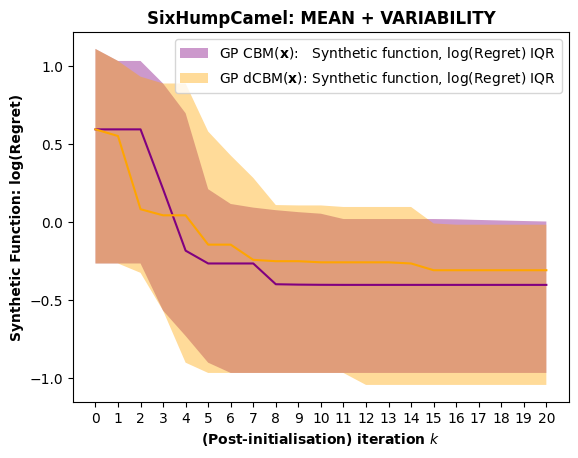

In [163]:
### Visualise!

cbm_both = ': MEAN + VARIABILITY'
title = obj_func + cbm_both

plt.figure()

plt.plot(median_approx, color = 'Purple')
plt.plot(median_exact, color = 'Orange')

xstar = np.arange(0, max_iter+1, step=1)
plt.fill_between(xstar, lower_approx, upper_approx, facecolor = 'Purple', alpha=0.4, label='GP CBM($\mathbf{x}$):   Synthetic function, log(Regret) IQR')
plt.fill_between(xstar, lower_exact, upper_exact, facecolor = 'Orange', alpha=0.4, label='GP dCBM($\mathbf{x}$): Synthetic function, log(Regret) IQR')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialisation) iteration $\it{k}$', weight = 'bold') # x-axis label
plt.ylabel('Synthetic Function: log(Regret)', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show()


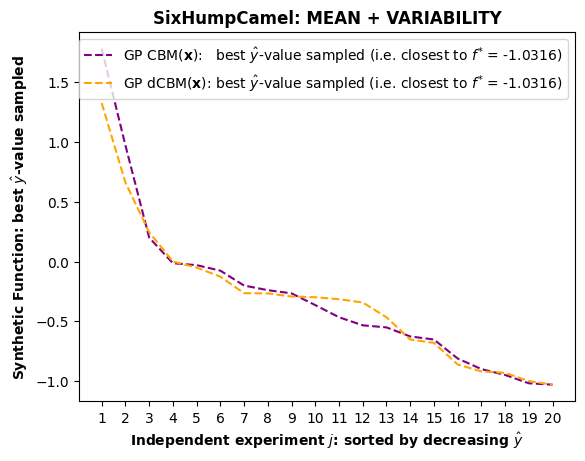

In [164]:
### Visualise!

cbm_both = ': MEAN + VARIABILITY'
title = obj_func + cbm_both

plt.figure()

plt.plot(np.sort(approx_tau)[::-1], color = 'Purple', ls='--', label='GP CBM($\mathbf{x}$):   best $\it{\hat{y}}$-value sampled (i.e. closest to $\it{f^{*}}$ = -1.0316)')
plt.plot(np.sort(exact_tau)[::-1], color = 'Orange', ls='--', label='GP dCBM($\mathbf{x}$): best $\it{\hat{y}}$-value sampled (i.e. closest to $\it{f^{*}}$ = -1.0316)')

xstar = np.arange(0, max_iter, step=1)

plt.title(title, weight = 'bold')
plt.xlabel('Independent experiment $\it{j}$: sorted by decreasing $\it{\hat{y}}$', weight = 'bold') # x-axis label
plt.ylabel('Synthetic Function: best $\it{\hat{y}}$-value sampled', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()


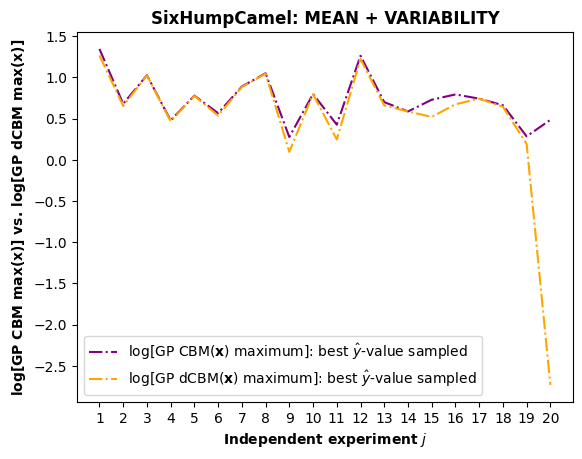

In [165]:
### Visualise!

cbm_both = ': MEAN + VARIABILITY'
title = obj_func + cbm_both

plt.figure()

plt.plot(np.log(exact_acqFuncApproxBest), color = 'Purple', ls='-.', label='log[GP CBM($\mathbf{x}$) maximum]: best $\it{\hat{y}}$-value sampled')
plt.plot(np.log(exact_acqFuncExactBest), color = 'Orange', ls='-.', label='log[GP dCBM($\mathbf{x}$) maximum]: best $\it{\hat{y}}$-value sampled')

xstar = np.arange(0, max_iter, step=1)

plt.title(title, weight = 'bold')
plt.xlabel('Independent experiment $\it{j}$', weight = 'bold') # x-axis label
plt.ylabel('log[GP CBM max($\mathbf{x}$)] vs. log[GP dCBM max($\mathbf{x}$)]', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()


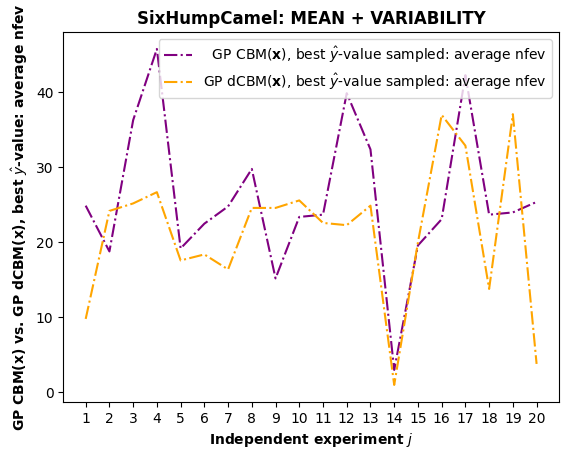

In [166]:
### Visualise!

cbm_both = ': MEAN + VARIABILITY'
title = obj_func + cbm_both

plt.figure()

plt.plot(approx_nfev_Avg, color = 'Purple', ls='-.', label='  GP CBM($\mathbf{x}$), best $\it{\hat{y}}$-value sampled: average nfev')
plt.plot(exact_nfev_Avg, color = 'Orange', ls='-.', label='GP dCBM($\mathbf{x}$), best $\it{\hat{y}}$-value sampled: average nfev')

xstar = np.arange(0, max_iter, step=1)

plt.title(title, weight = 'bold')
plt.xlabel('Independent experiment $\it{j}$', weight = 'bold') # x-axis label
plt.ylabel('GP CBM($\mathbf{x}$) vs. GP dCBM($\mathbf{x}$), best $\it{\hat{y}}$-value: average nfev', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()


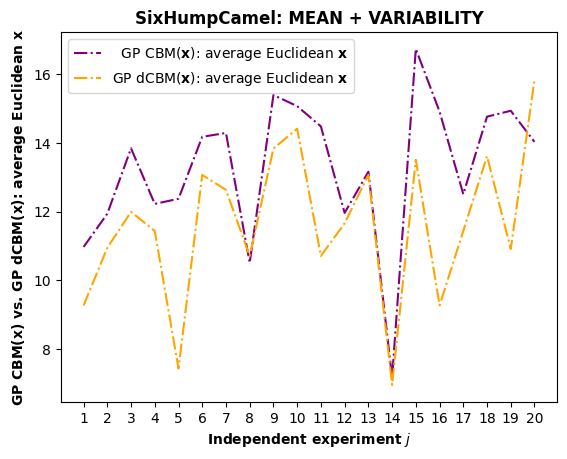

In [167]:
### Visualise!

cbm_both = ': MEAN + VARIABILITY'
title = obj_func + cbm_both

plt.figure()

plt.plot(approx_euclid_Avg, color = 'Purple', ls='-.', label='  GP CBM($\mathbf{x}$): average Euclidean $\mathbf{x}$')
plt.plot(exact_euclid_Avg, color = 'Orange', ls='-.', label='GP dCBM($\mathbf{x}$): average Euclidean $\mathbf{x}$')

xstar = np.arange(0, max_iter, step=1)

plt.title(title, weight = 'bold')
plt.xlabel('Independent experiment $\it{j}$', weight = 'bold') # x-axis label
plt.ylabel('GP CBM($\mathbf{x}$) vs. GP dCBM($\mathbf{x}$): average Euclidean $\mathbf{x}$', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()


In [168]:
np.round(-approx_4.f_best, 4), np.max(np.round(-approx_4.f_best, 4)), approx_4.best


(array([  1.9469, -16.1935,   1.9469,   0.7937,   1.9469,   1.9469,
          0.7937,   1.9469,   1.9469,   0.7937,   1.9469,   1.9469,
          1.9469,   1.9469,   1.9469,   0.7937,   1.9469,   1.9469,
          1.9469,   1.9469]),
 1.9469,
 array([ 0.12404132, -0.74799801]))

In [169]:
np.round(-approx_4.f_best2, 4), np.max(np.round(-approx_4.f_best2, 4)), approx_4.best2


(array([  1.6654, -16.1935,   1.6958,   1.2648,   0.6014,   1.8656,
        -16.1935,   1.1252,   0.7506,   0.6281,   1.3326,   1.2457,
          1.6509,   0.9453,   1.4845,   1.6009,   1.1149,   1.8906,
          1.8782,   1.3472]),
 1.8906,
 array([ 0.2163486 , -1.00160851]))

In [170]:
np.round(approx_4.x_best, 4)


array([[ 0.124 , -0.748 ],
       [ 3.    ,  2.    ],
       [ 0.124 , -0.748 ],
       [ 0.1881,  2.    ],
       [ 0.124 , -0.748 ],
       [ 0.124 , -0.748 ],
       [ 0.1881,  2.    ],
       [ 0.124 , -0.748 ],
       [ 0.124 , -0.748 ],
       [ 0.1881,  2.    ],
       [ 0.124 , -0.748 ],
       [ 0.124 , -0.748 ],
       [ 0.124 , -0.748 ],
       [ 0.124 , -0.748 ],
       [ 0.124 , -0.748 ],
       [ 0.1881,  2.    ],
       [ 0.124 , -0.748 ],
       [ 0.124 , -0.748 ],
       [ 0.124 , -0.748 ],
       [ 0.124 , -0.748 ]])

In [171]:
np.round(approx_4.x_best2, 4)


array([[-0.4708,  0.0967],
       [ 3.    ,  2.    ],
       [-0.4487,  0.072 ],
       [-0.5749,  0.3482],
       [ 0.1045,  1.5891],
       [-0.1872, -0.2573],
       [ 3.    ,  2.    ],
       [ 0.2413, -1.8065],
       [-0.4169,  0.7723],
       [ 0.1758,  1.7232],
       [-0.5671,  0.3129],
       [ 0.257 , -1.6874],
       [-0.4793,  0.1085],
       [-0.5887,  0.5013],
       [-0.544 ,  0.2215],
       [-0.4982,  0.1523],
       [ 0.2391, -1.818 ],
       [ 0.2163, -1.0016],
       [ 0.2229, -1.0263],
       [-0.5807,  0.2889]])

In [172]:
np.sqrt(np.sum((approx_4.start_points_arr - approx_4.x_best)**2))


10.064641766442783

In [173]:
np.sqrt(np.sum((approx_4.start_points_arr - approx_4.x_best2)**2))

9.023374243957695